In [1]:
import os
import logging
import numpy as np
from typing import *
import httpx
import asyncio
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import nest_asyncio
logger = logging.getLogger('test')

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger("httpx").setLevel(logging.WARNING)

nest_asyncio.apply()

In [2]:
plt.rcParams['font.family'] = "PingFang HK"
embedding_dir = r'C:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds'

base_url = "https://api.siliconflow.cn/v1/embeddings"
payload_model = "Pro/BAAI/bge-m3"
api_key = os.environ.get("DEEPSEEK_API_KEY")

## Embedding-based Cultural Projection

In [3]:
# —— 固定维度和缩写 —— #
DIM_ORDER = [
    ("power_distance",                "PDI"),
    ("individualism",                 "IDV"),
    ("motivation_towards_achievement","MAS"),
    ("uncertainty_avoidance",         "UAI"),
    ("long_term_orientation",         "LTO"),
    ("indulgence",                    "IND"),
]

DIM_ORDER_DICT = {
    "power_distance":                "PDI",
    "individualism":                 "IDV",
    "motivation_towards_achievement":"MAS",
    "uncertainty_avoidance":         "UAI",
    "long_term_orientation":         "LTO",
    "indulgence":                    "IND",
}

In [4]:
HOFSTEDE_REFERENCE = {
    "china":  {
        "power_distance": 80, "individualism": 20, "motivation_towards_achievement": 66,
        "uncertainty_avoidance": 30, "long_term_orientation": 87, "indulgence": 24,
    },
    "france": {
        "power_distance": 68, "individualism": 71, "motivation_towards_achievement": 43,
        "uncertainty_avoidance": 86, "long_term_orientation": 63, "indulgence": 48,
    },
}

HOFSTEDE_FINANCE_ZH = {
     "power_distance": {
        "pos": [{"txt": "集中管理", "w": 2}, {"txt": "风险审批流程", "w": 1.5}, {"txt": "监管指导", "w": 1}],
        "neg": [{"txt": "灵活授权", "w": 2}, {"txt": "自主定价", "w": 1.5}, {"txt": "团队共识", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "客户定制", "w": 2}, {"txt": "个性化服务", "w": 1.5}, {"txt": "客户自主选择", "w": 1}],
        "neg": [{"txt": "标准产品", "w": 2}, {"txt": "统一服务流程", "w": 1.5}, {"txt": "协作理赔", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "市场份额", "w": 2}, {"txt": "保费增长", "w": 1.5}, {"txt": "利润导向", "w": 1}],
        "neg": [{"txt": "客户满意度", "w": 2}, {"txt": "服务体验", "w": 1.5}, {"txt": "价值共创", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "风控体系", "w": 2}, {"txt": "合规要求", "w": 1.5}, {"txt": "偿付能力监管", "w": 1}],
        "neg": [{"txt": "产品创新", "w": 2}, {"txt": "技术试点", "w": 1.5}, {"txt": "灵活定价", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "养老保险", "w": 2}, {"txt": "战略投资", "w": 1.5}, {"txt": "长期资金配置", "w": 1}],
        "neg": [{"txt": "短期收益", "w": 2}, {"txt": "高频交易", "w": 1.5}, {"txt": "快速回报", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "用户体验", "w": 2}, {"txt": "服务便捷化", "w": 1.5}, {"txt": "多元服务", "w": 1}],
        "neg": [{"txt": "流程合规", "w": 2}, {"txt": "条款控制", "w": 1.5}, {"txt": "赔付审查", "w": 1}],
    }
}

HOFSTEDE_FINANCE_FR = {
    "power_distance": {
        "pos": [{"txt": "gestion centralisée", "w": 2}, {"txt": "contrôle des risques", "w": 1.5}, {"txt": "directive réglementaire", "w": 1}],
        "neg": [{"txt": "autonomie opérationnelle", "w": 2}, {"txt": "tarification décentralisée", "w": 1.5}, {"txt": "collaboration agile", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "personnalisation produit", "w": 2}, {"txt": "liberté de choix", "w": 1.5}, {"txt": "indépendance du client", "w": 1}],
        "neg": [{"txt": "produits standardisés", "w": 2}, {"txt": "procédure harmonisée", "w": 1.5}, {"txt": "gestion collective", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "croissance du chiffre d'affaires", "w": 2}, {"txt": "objectif de performance", "w": 1.5}, {"txt": "rentabilité financière", "w": 1}],
        "neg": [{"txt": "satisfaction client", "w": 2}, {"txt": "qualité de service", "w": 1.5}, {"txt": "co-création de valeur", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "gestion des risques", "w": 2}, {"txt": "réglementation prudentielle", "w": 1.5}, {"txt": "contrôle de solvabilité", "w": 1}],
        "neg": [{"txt": "expérimentation", "w": 2}, {"txt": "flexibilité tarifaire", "w": 1.5}, {"txt": "innovation assurantielle", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "vision à long terme", "w": 2}, {"txt": "placement stratégique", "w": 1.5}, {"txt": "investissement durable", "w": 1}],
        "neg": [{"txt": "rendement immédiat", "w": 2}, {"txt": "rotation rapide", "w": 1.5}, {"txt": "gains court terme", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "expérience utilisateur", "w": 2}, {"txt": "fluidité du parcours client", "w": 1.5}, {"txt": "accès multi-canal", "w": 1}],
        "neg": [{"txt": "contrôle des conditions", "w": 2}, {"txt": "processus rigide", "w": 1.5}, {"txt": "examen contractuel", "w": 1}],
    },
}


HOFSTEDE_PUBLIC_SERVICES_ZH = {
    "power_distance": {
        "pos": [{"txt": "统筹部署", "w": 2}, {"txt": "上下贯通", "w": 1.5}, {"txt": "集中管控", "w": 1}],
        "neg": [{"txt": "基层自治", "w": 2}, {"txt": "分层共建", "w": 1.5}, {"txt": "职责下沉", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "个性服务", "w": 2}, {"txt": "按需推送", "w": 1.5}, {"txt": "用户自选", "w": 1}],
        "neg": [{"txt": "统一标准", "w": 2}, {"txt": "公共规则", "w": 1.5}, {"txt": "集中化供给", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "绩效评估", "w": 2}, {"txt": "服务时效", "w": 1.5}, {"txt": "数据驱动管理", "w": 1}],
        "neg": [{"txt": "群众满意", "w": 2}, {"txt": "人本关怀", "w": 1.5}, {"txt": "包容服务", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "制度规范", "w": 2}, {"txt": "流程合规", "w": 1.5}, {"txt": "审计监督", "w": 1}],
        "neg": [{"txt": "制度创新", "w": 2}, {"txt": "流程重构", "w": 1.5}, {"txt": "灵活治理", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "五年规划", "w": 2}, {"txt": "数字基建", "w": 1.5}, {"txt": "体系建设", "w": 1}],
        "neg": [{"txt": "短期试点", "w": 2}, {"txt": "临时政策", "w": 1.5}, {"txt": "即时响应", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "政民互动", "w": 2}, {"txt": "服务便利化", "w": 1.5}, {"txt": "移动政务", "w": 1}],
        "neg": [{"txt": "服务审批层层把关", "w": 2}, {"txt": "职责流程严格", "w": 1.5}, {"txt": "履职规范", "w": 1}],
    }
}

HOFSTEDE_PUBLIC_SERVICES_FR = {
    "power_distance": {
        "pos": [{"txt": "pilotage centralisé", "w": 2}, {"txt": "chaîne hiérarchique", "w": 1.5}, {"txt": "commandement unifié", "w": 1}],
        "neg": [{"txt": "empowerment local", "w": 2}, {"txt": "co-construction territoriale", "w": 1.5}, {"txt": "subsidiarité", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "personnalisation des services", "w": 2}, {"txt": "offre modulable", "w": 1.5}, {"txt": "choix individuel", "w": 1}],
        "neg": [{"txt": "normes unifiées", "w": 2}, {"txt": "règles collectives", "w": 1.5}, {"txt": "distribution centralisée", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "évaluation de performance", "w": 2}, {"txt": "délai de traitement", "w": 1.5}, {"txt": "pilotage par les résultats", "w": 1}],
        "neg": [{"txt": "écoute citoyenne", "w": 2}, {"txt": "accueil bienveillant", "w": 1.5}, {"txt": "inclusion sociale", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "cadre réglementaire", "w": 2}, {"txt": "procédures de contrôle", "w": 1.5}, {"txt": "audit systématique", "w": 1}],
        "neg": [{"txt": "réinvention des pratiques", "w": 2}, {"txt": "refonte des procédures", "w": 1.5}, {"txt": "souplesse administrative", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "vision de long terme", "w": 2}, {"txt": "infrastructure numérique", "w": 1.5}, {"txt": "construction systémique", "w": 1}],
        "neg": [{"txt": "mesure provisoire", "w": 2}, {"txt": "projet court terme", "w": 1.5}, {"txt": "réactivité immédiate", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "interaction citoyenne", "w": 2}, {"txt": "démarches simplifiées", "w": 1.5}, {"txt": "guichet numérique mobile", "w": 1}],
        "neg": [{"txt": "sécurité administrative", "w": 2}, {"txt": "filtrage institutionnel", "w": 1.5}, {"txt": "contrôle hiérarchique", "w": 1}],
    }
}

HOFSTEDE_INDUSTRIAL_ZH = {
    "power_distance": {
        "pos": [{"txt": "集中调度", "w": 2}, {"txt": "上级指令", "w": 1.5}, {"txt": "岗位固定", "w": 1}],
        "neg": [{"txt": "岗位轮换", "w": 2}, {"txt": "操作自主", "w": 1.5}, {"txt": "工作协商", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "个人责任制", "w": 2}, {"txt": "自主操作台", "w": 1.5}, {"txt": "定制工序", "w": 1}],
        "neg": [{"txt": "标准工序", "w": 2}, {"txt": "团队生产", "w": 1.5}, {"txt": "协同作业", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "产能目标", "w": 2}, {"txt": "效率提升", "w": 1.5}, {"txt": "成本优化", "w": 1}],
        "neg": [{"txt": "操作舒适", "w": 2}, {"txt": "健康优先", "w": 1.5}, {"txt": "工人满意度", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "质量手册", "w": 2}, {"txt": "标准流程", "w": 1.5}, {"txt": "零缺陷", "w": 1}],
        "neg": [{"txt": "快速试产", "w": 2}, {"txt": "流程优化中", "w": 1.5}, {"txt": "实验性方案", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "设备更新规划", "w": 2}, {"txt": "可持续产线", "w": 1.5}, {"txt": "制造强国战略", "w": 1}],
        "neg": [{"txt": "订单驱动", "w": 2}, {"txt": "市场反应速度", "w": 1.5}, {"txt": "短期投产", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "人机协同", "w": 2}, {"txt": "情绪识别系统", "w": 1.5}, {"txt": "操作人性化", "w": 1}],
        "neg": [{"txt": "刚性工位", "w": 2}, {"txt": "流程定死", "w": 1.5}, {"txt": "反复重复操作", "w": 1}],
    }
}

HOFSTEDE_INDUSTRIAL_FR = {
    "power_distance": {
        "pos": [{"txt": "supervision hiérarchique", "w": 2}, {"txt": "chaîne de commandement", "w": 1.5}, {"txt": "poste assigné", "w": 1}],
        "neg": [{"txt": "polyvalence des opérateurs", "w": 2}, {"txt": "autonomie de poste", "w": 1.5}, {"txt": "collaboration horizontale", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "poste autonome", "w": 2}, {"txt": "initiative personnelle", "w": 1.5}, {"txt": "ajustement individuel", "w": 1}],
        "neg": [{"txt": "travail en équipe", "w": 2}, {"txt": "procédure unifiée", "w": 1.5}, {"txt": "production coordonnée", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "objectif de production", "w": 2}, {"txt": "gain de productivité", "w": 1.5}, {"txt": "réduction des coûts", "w": 1}],
        "neg": [{"txt": "ergonomie du poste", "w": 2}, {"txt": "santé au travail", "w": 1.5}, {"txt": "satisfaction opérateur", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "manuel qualité", "w": 2}, {"txt": "procédure ISO", "w": 1.5}, {"txt": "contrôle rigoureux", "w": 1}],
        "neg": [{"txt": "prototype agile", "w": 2}, {"txt": "amélioration continue", "w": 1.5}, {"txt": "approche exploratoire", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "plan d’investissement", "w": 2}, {"txt": "ligne durable", "w": 1.5}, {"txt": "vision industrielle", "w": 1}],
        "neg": [{"txt": "production à la commande", "w": 2}, {"txt": "time-to-market", "w": 1.5}, {"txt": "rentabilité immédiate", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "cobotique", "w": 2}, {"txt": "interface conviviale", "w": 1.5}, {"txt": "ergonomie assistée", "w": 1}],
        "neg": [{"txt": "poste contraint", "w": 2}, {"txt": "procédure rigide", "w": 1.5}, {"txt": "répétitivité forcée", "w": 1}],
    }
}


HOFSTEDE_HEALTHCARE_ZH = {
    "power_distance": {
        "pos": [{"txt": "三级诊疗制度", "w": 2}, {"txt": "听从医嘱", "w": 1.5}, {"txt": "分级授权", "w": 1}],
        "neg": [{"txt": "医患共决策", "w": 2}, {"txt": "知情选择", "w": 1.5}, {"txt": "患者主导", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "个性化治疗方案", "w": 2}, {"txt": "定制康复计划", "w": 1.5}, {"txt": "患者偏好", "w": 1}],
        "neg": [{"txt": "统一诊疗路径", "w": 2}, {"txt": "集体会诊", "w": 1.5}, {"txt": "标准流程", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "绩效考核", "w": 2}, {"txt": "手术成功率", "w": 1.5}, {"txt": "服务量增长", "w": 1}],
        "neg": [{"txt": "医患关系质量", "w": 2}, {"txt": "满意度调查", "w": 1.5}, {"txt": "人文关怀", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "诊疗规范", "w": 2}, {"txt": "医学指南", "w": 1.5}, {"txt": "多重审批", "w": 1}],
        "neg": [{"txt": "灵活诊疗", "w": 2}, {"txt": "经验判断", "w": 1.5}, {"txt": "动态评估", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "慢病管理", "w": 2}, {"txt": "公共卫生规划", "w": 1.5}, {"txt": "预防优先", "w": 1}],
        "neg": [{"txt": "短期救治", "w": 2}, {"txt": "应急处置", "w": 1.5}, {"txt": "单次疗效", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "康复体验", "w": 2}, {"txt": "健康促进", "w": 1.5}, {"txt": "人性化服务", "w": 1}],
        "neg": [{"txt": "治疗至上", "w": 2}, {"txt": "以病为中心", "w": 1.5}, {"txt": "临床优先", "w": 1}],
    }
}

HOFSTEDE_HEALTHCARE_FR = {
    "power_distance": {
        "pos": [{"txt": "hiérarchie médicale", "w": 2}, {"txt": "suivi de prescription", "w": 1.5}, {"txt": "autorité clinique", "w": 1}],
        "neg": [{"txt": "co-décision médicale", "w": 2}, {"txt": "consentement éclairé", "w": 1.5}, {"txt": "autonomie du patient", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "plan de soins personnalisé", "w": 2}, {"txt": "préférence patient", "w": 1.5}, {"txt": "approche individualisée", "w": 1}],
        "neg": [{"txt": "protocole unique", "w": 2}, {"txt": "prise en charge coordonnée", "w": 1.5}, {"txt": "traitement standardisé", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "indicateurs de performance", "w": 2}, {"txt": "taux de réussite opératoire", "w": 1.5}, {"txt": "rendement hospitalier", "w": 1}],
        "neg": [{"txt": "qualité relationnelle", "w": 2}, {"txt": "soutien psychologique", "w": 1.5}, {"txt": "prise en charge empathique", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "protocole médical", "w": 2}, {"txt": "référentiel clinique", "w": 1.5}, {"txt": "validation plurielle", "w": 1}],
        "neg": [{"txt": "adaptation continue", "w": 2}, {"txt": "jugement clinique", "w": 1.5}, {"txt": "ajustement in situ", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "prévention santé", "w": 2}, {"txt": "suivi de long terme", "w": 1.5}, {"txt": "planification sanitaire", "w": 1}],
        "neg": [{"txt": "intervention ponctuelle", "w": 2}, {"txt": "gestion d'urgence", "w": 1.5}, {"txt": "résultat immédiat", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "bien-être patient", "w": 2}, {"txt": "promotion de la santé", "w": 1.5}, {"txt": "soins chaleureux", "w": 1}],
        "neg": [{"txt": "soins centrés sur la maladie", "w": 2}, {"txt": "strict protocole clinique", "w": 1.5}, {"txt": "priorité au diagnostic", "w": 1}],
    }
}

HOFSTEDE_EDUCATION_ZH = {
    "power_distance": {
        "pos": [{"txt": "教学指令", "w": 2}, {"txt": "统一部署", "w": 1.5}, {"txt": "校长负责制", "w": 1}],
        "neg": [{"txt": "教学自治", "w": 2}, {"txt": "教师共治", "w": 1.5}, {"txt": "平等对话", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "因材施教", "w": 2}, {"txt": "个性化学习路径", "w": 1.5}, {"txt": "学生自主选择", "w": 1}],
        "neg": [{"txt": "统一课程", "w": 2}, {"txt": "集体目标", "w": 1.5}, {"txt": "小组共建", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "考试成绩", "w": 2}, {"txt": "升学率", "w": 1.5}, {"txt": "指标导向", "w": 1}],
        "neg": [{"txt": "学习兴趣", "w": 2}, {"txt": "能力提升", "w": 1.5}, {"txt": "终身学习", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "教学规范", "w": 2}, {"txt": "统一教学计划", "w": 1.5}, {"txt": "规章制度", "w": 1}],
        "neg": [{"txt": "探索式学习", "w": 2}, {"txt": "项目制教学", "w": 1.5}, {"txt": "灵活调整", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "素质教育", "w": 2}, {"txt": "未来适应力", "w": 1.5}, {"txt": "阶段性成长", "w": 1}],
        "neg": [{"txt": "短期分数", "w": 2}, {"txt": "应试导向", "w": 1.5}, {"txt": "速成教育", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "学习体验", "w": 2}, {"txt": "兴趣引导", "w": 1.5}, {"txt": "积极情绪", "w": 1}],
        "neg": [{"txt": "严格管理", "w": 2}, {"txt": "纪律优先", "w": 1.5}, {"txt": "高压教学", "w": 1}],
    }
}

HOFSTEDE_EDUCATION_FR = {
    "power_distance": {
        "pos": [{"txt": "directive pédagogique", "w": 2}, {"txt": "pilotage académique", "w": 1.5}, {"txt": "autorité scolaire", "w": 1}],
        "neg": [{"txt": "autonomie pédagogique", "w": 2}, {"txt": "codécision éducative", "w": 1.5}, {"txt": "dialogue horizontal", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "apprentissage personnalisé", "w": 2}, {"txt": "liberté d’apprentissage", "w": 1.5}, {"txt": "choix individuel", "w": 1}],
        "neg": [{"txt": "programme standard", "w": 2}, {"txt": "objectif collectif", "w": 1.5}, {"txt": "apprentissage coopératif", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "résultats aux examens", "w": 2}, {"txt": "taux de réussite", "w": 1.5}, {"txt": "objectif de performance", "w": 1}],
        "neg": [{"txt": "motivation intrinsèque", "w": 2}, {"txt": "développement personnel", "w": 1.5}, {"txt": "apprentissage durable", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "programme rigide", "w": 2}, {"txt": "normes pédagogiques", "w": 1.5}, {"txt": "instruction cadrée", "w": 1}],
        "neg": [{"txt": "apprentissage exploratoire", "w": 2}, {"txt": "enseignement par projet", "w": 1.5}, {"txt": "flexibilité didactique", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "compétences transversales", "w": 2}, {"txt": "projection professionnelle", "w": 1.5}, {"txt": "parcours évolutif", "w": 1}],
        "neg": [{"txt": "réussite immédiate", "w": 2}, {"txt": "objectifs à court terme", "w": 1.5}, {"txt": "formation accélérée", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "expérience d’apprentissage", "w": 2}, {"txt": "curiosité cognitive", "w": 1.5}, {"txt": "émotions positives", "w": 1}],
        "neg": [{"txt": "discipline stricte", "w": 2}, {"txt": "autorité en classe", "w": 1.5}, {"txt": "pression scolaire", "w": 1}],
    }
}


In [5]:
# -------- ZH --------
HOFSTEDE_FINANCE_ZH["uncertainty_avoidance"] = {
    "pos": [  # 高 UAI：保守、刚性、合规
        {"txt": "风险零容忍",       "w": 2},
        {"txt": "穿透式监管",       "w": 2},
        {"txt": "全流程合规",       "w": 1.5},
        {"txt": "严格事前审批",     "w": 1.5},
        {"txt": "步骤锁定",         "w": 1},
        {"txt": "逐级问责",         "w": 1},
    ],
    "neg": [  # 低 UAI：试错、沙盒、灵活
        {"txt": "先上线后备案",     "w": 2},
        {"txt": "金融沙盒",         "w": 2},
        {"txt": "快速灰度发布",     "w": 1.5},
        {"txt": "灵活费率调整",     "w": 1.5},
        {"txt": "宽容试错",         "w": 1},
        {"txt": "动态迭代",         "w": 1},
    ],
}

# -------- FR --------
HOFSTEDE_FINANCE_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "tolérance zéro risque",        "w": 2},
        {"txt": "supervision pénétrante",       "w": 2},
        {"txt": "conformité intégrale",         "w": 1.5},
        {"txt": "approbation préalable stricte","w": 1.5},
        {"txt": "étapes verrouillées",          "w": 1},
        {"txt": "responsabilité hiérarchique",  "w": 1},
    ],
    "neg": [
        {"txt": "lancer puis déclarer",         "w": 2},
        {"txt": "sandbox financier",            "w": 2},
        {"txt": "déploiement incrémental rapide","w": 1.5},
        {"txt": "flexibilité tarifaire",        "w": 1.5},
        {"txt": "droit à l’erreur",             "w": 1},
        {"txt": "itération continue",           "w": 1},
    ],
}

HOFSTEDE_PUBLIC_SERVICES_ZH["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "审计全覆盖",       "w": 2},
        {"txt": "制度刚性执行",     "w": 2},
        {"txt": "严格行政审批",     "w": 1.5},
        {"txt": "流程锁定",         "w": 1.5},
        {"txt": "逐级问责",         "w": 1},
        {"txt": "零差错目标",       "w": 1},
    ],
    "neg": [
        {"txt": "一次性承诺制",     "w": 2},
        {"txt": "简易备案",         "w": 2},
        {"txt": "试点先行",         "w": 1.5},
        {"txt": "灵活治理",         "w": 1.5},
        {"txt": "宽容试错",         "w": 1},
        {"txt": "快速响应",         "w": 1},
    ],
}

HOFSTEDE_PUBLIC_SERVICES_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "audit systématique",                   "w": 2},
        {"txt": "exécution réglementaire rigide",      "w": 2},
        {"txt": "approbation administrative stricte",  "w": 1.5},
        {"txt": "processus verrouillé",                "w": 1.5},
        {"txt": "responsabilité hiérarchique",         "w": 1},
        {"txt": "objectif zéro faute",                 "w": 1},
    ],
    "neg": [
        {"txt": "guichet engagement unique",           "w": 2},
        {"txt": "déclaration simplifiée",              "w": 2},
        {"txt": "pilote territorial",                  "w": 1.5},
        {"txt": "gouvernance flexible",                "w": 1.5},
        {"txt": "droit à l’erreur",                    "w": 1},
        {"txt": "réponse rapide",                      "w": 1},
    ],
}

HOFSTEDE_INDUSTRIAL_ZH["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "质量红线",         "w": 2},
        {"txt": "停线即复盘",       "w": 2},
        {"txt": "严格工艺卡控",     "w": 1.5},
        {"txt": "零缺陷目标",       "w": 1.5},
        {"txt": "安全票证",         "w": 1},
        {"txt": "风险清单闭环",     "w": 1},
    ],
    "neg": [
        {"txt": "沙盒试产",         "w": 2},
        {"txt": "快速迭代工艺",     "w": 2},
        {"txt": "小批量试错",       "w": 1.5},
        {"txt": "灵活换线",         "w": 1.5},
        {"txt": "探索性方案",       "w": 1},
        {"txt": "持续改进",         "w": 1},
    ],
}

HOFSTEDE_INDUSTRIAL_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "ligne rouge qualité",                  "w": 2},
        {"txt": "arrêt et autopsie immédiats",          "w": 2},
        {"txt": "contrôle de procédé strict",           "w": 1.5},
        {"txt": "objectif zéro défaut",                 "w": 1.5},
        {"txt": "permis sécurité",                      "w": 1},
        {"txt": "boucle fermée des risques",            "w": 1},
    ],
    "neg": [
        {"txt": "prototype en sandbox",                 "w": 2},
        {"txt": "procédé itératif rapide",              "w": 2},
        {"txt": "petite série d’essai",                 "w": 1.5},
        {"txt": "changement de ligne flexible",         "w": 1.5},
        {"txt": "approche exploratoire",                "w": 1},
        {"txt": "amélioration continue",                "w": 1},
    ],
}

HOFSTEDE_HEALTHCARE_ZH["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "双盲指南刚性",     "w": 2},
        {"txt": "严格诊疗规范",     "w": 2},
        {"txt": "多级会诊审批",     "w": 1.5},
        {"txt": "零误诊目标",       "w": 1.5},
        {"txt": "处方审核闭环",     "w": 1},
        {"txt": "医疗事故零容忍",   "w": 1},
    ],
    "neg": [
        {"txt": "个体化临床判断",   "w": 2},
        {"txt": "动态病程调整",     "w": 2},
        {"txt": "适时用药试验",     "w": 1.5},
        {"txt": "灵活诊疗路径",     "w": 1.5},
        {"txt": "临床适应性调整",   "w": 1},
        {"txt": "宽容探索",         "w": 1},
    ],
}

HOFSTEDE_HEALTHCARE_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "protocole double aveugle rigide",       "w": 2},
        {"txt": "référentiel clinique strict",          "w": 2},
        {"txt": "validation pluri-étapes",              "w": 1.5},
        {"txt": "objectif zéro erreur",                 "w": 1.5},
        {"txt": "boucle fermée des prescriptions",      "w": 1},
        {"txt": "tolérance zéro incident",              "w": 1},
    ],
    "neg": [
        {"txt": "jugement clinique individuel",         "w": 2},
        {"txt": "ajustement dynamique",                 "w": 2},
        {"txt": "essai thérapeutique in situ",          "w": 1.5},
        {"txt": "parcours de soins flexible",           "w": 1.5},
        {"txt": "adaptation clinique",                  "w": 1},
        {"txt": "droit à l’expérimentation",            "w": 1},
    ],
}

HOFSTEDE_EDUCATION_ZH["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "统一教学大纲",     "w": 2},
        {"txt": "标准考试规则",     "w": 2},
        {"txt": "严格成绩评定",     "w": 1.5},
        {"txt": "课程锁定",         "w": 1.5},
        {"txt": "零偏差批改",       "w": 1},
        {"txt": "分层审批",         "w": 1},
    ],
    "neg": [
        {"txt": "项目制探究",       "w": 2},
        {"txt": "自主选题",         "w": 2},
        {"txt": "开放评价",         "w": 1.5},
        {"txt": "灵活调整进度",     "w": 1.5},
        {"txt": "探索式学习",       "w": 1},
        {"txt": "宽容失败",         "w": 1},
    ],
}

HOFSTEDE_EDUCATION_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "programme national unique",            "w": 2},
        {"txt": "règles d’examen standard",             "w": 2},
        {"txt": "notation strictement normée",          "w": 1.5},
        {"txt": "cours verrouillés",                    "w": 1.5},
        {"txt": "correction zéro biais",                "w": 1},
        {"txt": "hiérarchie d’approbation",             "w": 1},
    ],
    "neg": [
        {"txt": "apprentissage par projet",             "w": 2},
        {"txt": "sujet auto-choisi",                    "w": 2},
        {"txt": "évaluation ouverte",                   "w": 1.5},
        {"txt": "rythme d’apprentissage flexible",      "w": 1.5},
        {"txt": "apprentissage exploratoire",           "w": 1},
        {"txt": "droit à l’échec",                      "w": 1},
    ],
}


In [6]:
ALL = [ HOFSTEDE_FINANCE_ZH, HOFSTEDE_FINANCE_FR,
        HOFSTEDE_PUBLIC_SERVICES_ZH, HOFSTEDE_PUBLIC_SERVICES_FR,
        HOFSTEDE_INDUSTRIAL_ZH, HOFSTEDE_INDUSTRIAL_FR,
        HOFSTEDE_HEALTHCARE_ZH, HOFSTEDE_HEALTHCARE_FR,
        HOFSTEDE_EDUCATION_ZH, HOFSTEDE_EDUCATION_FR]

HOFSTEDE_ANCHOR_SETS = {
    "power_distance": {
        "pos": sum([H["power_distance"]["pos"] for H in ALL], []),
        "neg": sum([H["power_distance"]["neg"] for H in ALL], []),
    },
    
    "uncertainty_avoidance": {
        "pos": sum([H["uncertainty_avoidance"]["pos"] for H in ALL], []),
        "neg": sum([H["uncertainty_avoidance"]["neg"] for H in ALL], []),
    },
    "motivation_towards_achievement": {
        "pos": sum([H["motivation_towards_achievement"]["pos"] for H in ALL], []),
        "neg": sum([H["motivation_towards_achievement"]["neg"] for H in ALL], []),
    },
    "individualism": {
        "pos": sum([H["individualism"]["pos"] for H in ALL], []),
        "neg": sum([H["individualism"]["neg"] for H in ALL], []),
    },
    "long_term_orientation": {
        "pos": sum([H["long_term_orientation"]["pos"] for H in ALL], []),
        "neg": sum([H["long_term_orientation"]["neg"] for H in ALL], []),
    },
    "indulgence": {
        "pos": sum([H["indulgence"]["pos"] for H in ALL], []),
        "neg": sum([H["indulgence"]["neg"] for H in ALL], []),
    }
}

In [ ]:
async def _get_embedding(text: str, timeout: float = 60.0) -> List[float]:
    """Call SiliconFlow, return embedding list."""
    payload = {"model": payload_model, "input": text, "encoding_format": "float"}
    headers = {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}
    async with httpx.AsyncClient(timeout=timeout) as client:
        r = await client.post(base_url, json=payload, headers=headers)
        r.raise_for_status()
        return r.json()["data"][0]["embedding"]

async def _compute_anchor_vectors(anchor_sets):
    from collections import defaultdict

    # Step 1: 构造任务列表
    all_tasks = []
    meta_info = []  # 记录每个任务属于哪个维度、极性、权重

    for dim, groups in anchor_sets.items():
        for polarity in ("pos", "neg"):
            for entry in groups[polarity]:
                all_tasks.append(_get_embedding(entry["txt"]))
                meta_info.append((dim, polarity, entry["w"]))

    # Step 2: 全局并发执行
    logger.info(f"🚀 Launching embedding requests for {len(all_tasks)} anchors…")
    embeddings = await asyncio.gather(*all_tasks)
    logger.info(f"✅ Completed all embeddings")
 
    # Step 3: 聚合为 anchor vectors
    vec_groups = defaultdict(lambda: {"pos": [], "neg": []})
    for (dim, polarity, weight), emb in zip(meta_info, embeddings):
        vec_groups[dim][polarity].append((np.array(emb), weight))

    anchor_vecs = {}
    for dim, group in vec_groups.items():
        pos_arr = np.stack([v * w for v, w in group["pos"]])
        neg_arr = np.stack([v * w for v, w in group["neg"]])
        pos_mean = pos_arr.sum(0) / (sum(w for _, w in group["pos"]) + 1e-8)
        neg_mean = neg_arr.sum(0) / (sum(w for _, w in group["neg"]) + 1e-8)
        v = pos_mean - neg_mean
        anchor_vecs[dim] = v / (np.linalg.norm(v) + 1e-8)
        logger.info(f"🎯 Anchor <{dim}> computed")

    return anchor_vecs


#%% -------------------- Projection & Aggregation --------------------
# def _process_country(country: str, anchor_vectors: Dict[str, np.ndarray]):
#     cache_file = os.path.join(embedding_dir, f"{country}_sentence_embs.npy")
#     logger.info(f"[{country}] load embeddings → {cache_file}")
#     embs = np.load(cache_file, mmap_mode="r")  # shape (N, 1024)

#     proj = {}
#     for dim, v in anchor_vectors.items():
#         scores = embs @ v                       # 点乘投影
#         proj[dim] = {"avg_value": float(scores.mean()), "std": float(scores.std())}
#     return proj

def _process_country(country: str, anchor_vectors):
    embs = np.load(os.path.join(embedding_dir, f"{country}_sentence_embs.npy"), mmap_mode="r")
    proj = {}
    for dim, v in anchor_vectors.items():
        scores = embs @ v
        # —— 去噪：仅保留强信号句 ——
        mask = np.abs(scores) > 0.05          # 阈值可调
        if mask.sum() == 0:                   # fallback
            mask = np.ones_like(scores, dtype=bool)
        clean = scores[mask]
        avg  = float(np.mean(clean))
        std  = float(np.std(clean))
        proj[dim] = {"avg_value": avg, "std": std, "n": int(mask.sum())}
    return proj


def analyze_cultural_dimensions(anchor_sets):
    loop = asyncio.get_event_loop()
    anchor_vectors = loop.run_until_complete(_compute_anchor_vectors(anchor_sets))

    results = {}
    for c in ("china", "france"):
        results[c] = _process_country(c, anchor_vectors)
    logger.info(f"Projection done → {results}")
    return results

In [8]:
def generate_cultural_radar_charts(
    cultural_results: dict,
    hofstede_dims: dict | None = HOFSTEDE_REFERENCE,   # ← 新增，可选
    ylim = (-0.1, 0.1),                # ← 新增，语义投影的 y 轴范围
    save_path: str | None = None
):
    """
    生成雷达图：
      • 左：语义投影结果（-0.1 ~ 0.1）
      • 右：官方 Hofstede 指数（0 ~ 100，只有传入 hofstede_dims 时才绘制）
    颜色：China = 红色，France = 蓝色；去掉极轴刻度数字
    """
    if not cultural_results:
        print("没有文化维度数据")
        return

    # ----------- 取值 ----------- #
    cn_proj = [cultural_results["china"][d]["avg_value"]   for d, _ in DIM_ORDER]
    fr_proj = [cultural_results["france"][d]["avg_value"]  for d, _ in DIM_ORDER]

    labels = [abbr for _, abbr in DIM_ORDER] + [DIM_ORDER[0][1]]
    cn_proj += [cn_proj[0]]
    fr_proj += [fr_proj[0]]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=True)

    # ----------- 画布设置 ----------- #
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=dict(polar=True))

    # ----------- 绘制语义投影 ----------- #
    ax_left = axes[0]
    ax_left.plot(angles, cn_proj, color="red",   lw=2, label="China")
    ax_left.fill(angles, cn_proj, color="red",   alpha=0.25)
    ax_left.plot(angles, fr_proj, color="blue",  lw=2, label="France")
    ax_left.fill(angles, fr_proj, color="blue",  alpha=0.25)
    ax_left.set_thetagrids(angles*180/np.pi, labels, fontsize=11)
    ax_left.set_ylim(*ylim)
    ax_left.set_yticklabels([])
    if ylim != (-0.1, 0.1):
        title = f"Semantic Projection (rescaled) {ylim}"
    else:
        title = "Semantic Projection (±0.1)"
    ax_left.set_title(title, pad=18)
    ax_left.grid(True)

    # ----------- 绘制官方指数----------- #
    cn_ref = [hofstede_dims["china"][d]  for d, _ in DIM_ORDER] + [hofstede_dims["china"][DIM_ORDER[0][0]]]
    fr_ref = [hofstede_dims["france"][d] for d, _ in DIM_ORDER] + [hofstede_dims["france"][DIM_ORDER[0][0]]]

    ax_right = axes[1]
    ax_right.plot(angles, cn_ref, color="red",  lw=2, label="China")
    ax_right.fill(angles, cn_ref, color="red",  alpha=0.25)
    ax_right.plot(angles, fr_ref, color="blue", lw=2, label="France")
    ax_right.fill(angles, fr_ref, color="blue", alpha=0.25)
    ax_right.set_thetagrids(angles*180/np.pi, labels, fontsize=11)
    ax_right.set_ylim(0, 100)
    ax_right.set_yticklabels([])
    ax_right.set_title("Hofstede Index (0 – 100)", pad=18)
    ax_right.grid(True)

    # ----------- 图例与保存 ----------- #
    axes[-1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.05))
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight", format="svg")
        plt.close("all")
    else:
        plt.show()

In [9]:
results = analyze_cultural_dimensions(HOFSTEDE_ANCHOR_SETS)
display(results)
generate_cultural_radar_charts(results, save_path="cultural_radar.svg")

2025-05-03 20:39:13,439 - INFO - 🚀 Launching embedding requests for 420 anchors…
2025-05-03 20:39:25,084 - INFO - ✅ Completed all embeddings
2025-05-03 20:39:25,109 - INFO - 🎯 Anchor <power_distance> computed
2025-05-03 20:39:25,111 - INFO - 🎯 Anchor <uncertainty_avoidance> computed
2025-05-03 20:39:25,113 - INFO - 🎯 Anchor <motivation_towards_achievement> computed
2025-05-03 20:39:25,114 - INFO - 🎯 Anchor <individualism> computed
2025-05-03 20:39:25,114 - INFO - 🎯 Anchor <long_term_orientation> computed
2025-05-03 20:39:25,116 - INFO - 🎯 Anchor <indulgence> computed
2025-05-03 20:39:28,047 - INFO - Projection done → {'china': {'power_distance': {'avg_value': 0.013425005683878489, 'std': 0.08146112470857102, 'n': 20555}, 'uncertainty_avoidance': {'avg_value': -0.07817533174573288, 'std': 0.05905912613632271, 'n': 34405}, 'motivation_towards_achievement': {'avg_value': 0.06292402719691742, 'std': 0.07881829544299385, 'n': 30162}, 'individualism': {'avg_value': 0.04717541170467782, 'std'

{'china': {'power_distance': {'avg_value': 0.013425005683878489,
   'std': 0.08146112470857102,
   'n': 20555},
  'uncertainty_avoidance': {'avg_value': -0.07817533174573288,
   'std': 0.05905912613632271,
   'n': 34405},
  'motivation_towards_achievement': {'avg_value': 0.06292402719691742,
   'std': 0.07881829544299385,
   'n': 30162},
  'individualism': {'avg_value': 0.04717541170467782,
   'std': 0.07500644235116065,
   'n': 22485},
  'long_term_orientation': {'avg_value': 0.0482918904903491,
   'std': 0.08252061175767221,
   'n': 30703},
  'indulgence': {'avg_value': 0.09831786421960778,
   'std': 0.0704183979560216,
   'n': 41214}},
 'france': {'power_distance': {'avg_value': -0.025283583971561243,
   'std': 0.08097814299363246,
   'n': 56283},
  'uncertainty_avoidance': {'avg_value': -0.09414501743271364,
   'std': 0.055020949883330804,
   'n': 100214},
  'motivation_towards_achievement': {'avg_value': -0.030684831415226193,
   'std': 0.08964090751557932,
   'n': 72479},
  'indi

C:\Users\ming\AppData\Local\Temp\ipykernel_19240\1350241090.py:62: UserWarning: Glyph 8198 (\N{SIX-PER-EM SPACE}) missing from font(s) PingFang HK.
  plt.tight_layout()
C:\Users\ming\AppData\Local\Temp\ipykernel_19240\1350241090.py:65: UserWarning: Glyph 8198 (\N{SIX-PER-EM SPACE}) missing from font(s) PingFang HK.
  plt.savefig(save_path, dpi=300, bbox_inches="tight", format="svg")


## 锚点验证

In [10]:
# Step 1: 构造中法锚点对
from collections import defaultdict
paired_texts = defaultdict(lambda: defaultdict(list))

for i in range(0, len(ALL), 2):
    zh_dict = ALL[i]
    fr_dict = ALL[i + 1]

    for dim in zh_dict:
        for polarity in ("pos", "neg"):
            zh_anchors = zh_dict[dim][polarity]
            fr_anchors = fr_dict[dim][polarity]
            for zh_entry, fr_entry in zip(zh_anchors, fr_anchors):
                paired_texts[dim][polarity].append((zh_entry["txt"], fr_entry["txt"]))

# Step 2: 批量嵌入 & 相似度计算
async def _compute_one_pair(dim, polarity, pairs):
    print(f"🔍 Embedding {dim} - {polarity} ...")
    zh_texts, fr_texts = zip(*pairs)
    zh_embs = await asyncio.gather(*[_get_embedding(txt) for txt in zh_texts])
    fr_embs = await asyncio.gather(*[_get_embedding(txt) for txt in fr_texts])
    zh_arr = np.stack(zh_embs)
    fr_arr = np.stack(fr_embs)
    dot = np.sum(zh_arr * fr_arr, axis=1)
    cos_sim = dot / (np.linalg.norm(zh_arr, axis=1) * np.linalg.norm(fr_arr, axis=1) + 1e-8)
    mean_val = float(np.mean(cos_sim))
    std_val = float(np.std(cos_sim))
    print(f"✅ Finished {dim} - {polarity} → mean: {mean_val:.4f}, std: {std_val:.4f}")
    return dim, polarity, {
        "mean_cosine": mean_val,
        "std": std_val,
        "count": len(cos_sim)
    }

async def compute_cosine_similarities_fast():
    print("🚀 Launching parallel similarity checks ...")
    tasks = []
    for dim in paired_texts:
        for polarity in paired_texts[dim]:
            pairs = paired_texts[dim][polarity]
            tasks.append(_compute_one_pair(dim, polarity, pairs))
    results = defaultdict(dict)
    for dim, polarity, stats in await asyncio.gather(*tasks):
        results[dim][polarity] = stats
    print("🎯 All dimension-polarity comparisons completed.")
    return dict(results)

similarity_stats = asyncio.run(compute_cosine_similarities_fast())

🚀 Launching parallel similarity checks ...
🔍 Embedding power_distance - pos ...
🔍 Embedding power_distance - neg ...
🔍 Embedding individualism - pos ...
🔍 Embedding individualism - neg ...
🔍 Embedding motivation_towards_achievement - pos ...
🔍 Embedding motivation_towards_achievement - neg ...
🔍 Embedding uncertainty_avoidance - pos ...
🔍 Embedding uncertainty_avoidance - neg ...
🔍 Embedding long_term_orientation - pos ...
🔍 Embedding long_term_orientation - neg ...
🔍 Embedding indulgence - pos ...
🔍 Embedding indulgence - neg ...
✅ Finished motivation_towards_achievement - pos → mean: 0.6850, std: 0.1379
✅ Finished indulgence - neg → mean: 0.5746, std: 0.1107
✅ Finished individualism - pos → mean: 0.6401, std: 0.1199
✅ Finished long_term_orientation - pos → mean: 0.5695, std: 0.1032
✅ Finished individualism - neg → mean: 0.6403, std: 0.1246
✅ Finished motivation_towards_achievement - neg → mean: 0.6464, std: 0.0906
✅ Finished indulgence - pos → mean: 0.6793, std: 0.1323
✅ Finished lon

In [11]:
similarity_stats

{'power_distance': {'pos': {'mean_cosine': 0.5962647833261998,
   'std': 0.08945854400648165,
   'count': 15},
  'neg': {'mean_cosine': 0.6197086774765204,
   'std': 0.10472185337717514,
   'count': 15}},
 'individualism': {'pos': {'mean_cosine': 0.6400778118528413,
   'std': 0.11988018626613654,
   'count': 15},
  'neg': {'mean_cosine': 0.6402797839065407,
   'std': 0.12463458654595738,
   'count': 15}},
 'motivation_towards_achievement': {'pos': {'mean_cosine': 0.6849807124810408,
   'std': 0.13786689457982093,
   'count': 15},
  'neg': {'mean_cosine': 0.6463786629461921,
   'std': 0.09056955810072177,
   'count': 15}},
 'uncertainty_avoidance': {'pos': {'mean_cosine': 0.6881341799923593,
   'std': 0.07945015078401797,
   'count': 30},
  'neg': {'mean_cosine': 0.6804086085291587,
   'std': 0.12248322204910064,
   'count': 30}},
 'long_term_orientation': {'pos': {'mean_cosine': 0.5695177236865075,
   'std': 0.10317456771084585,
   'count': 15},
  'neg': {'mean_cosine': 0.5923340678482

### 跨语言漂移锚点相似度

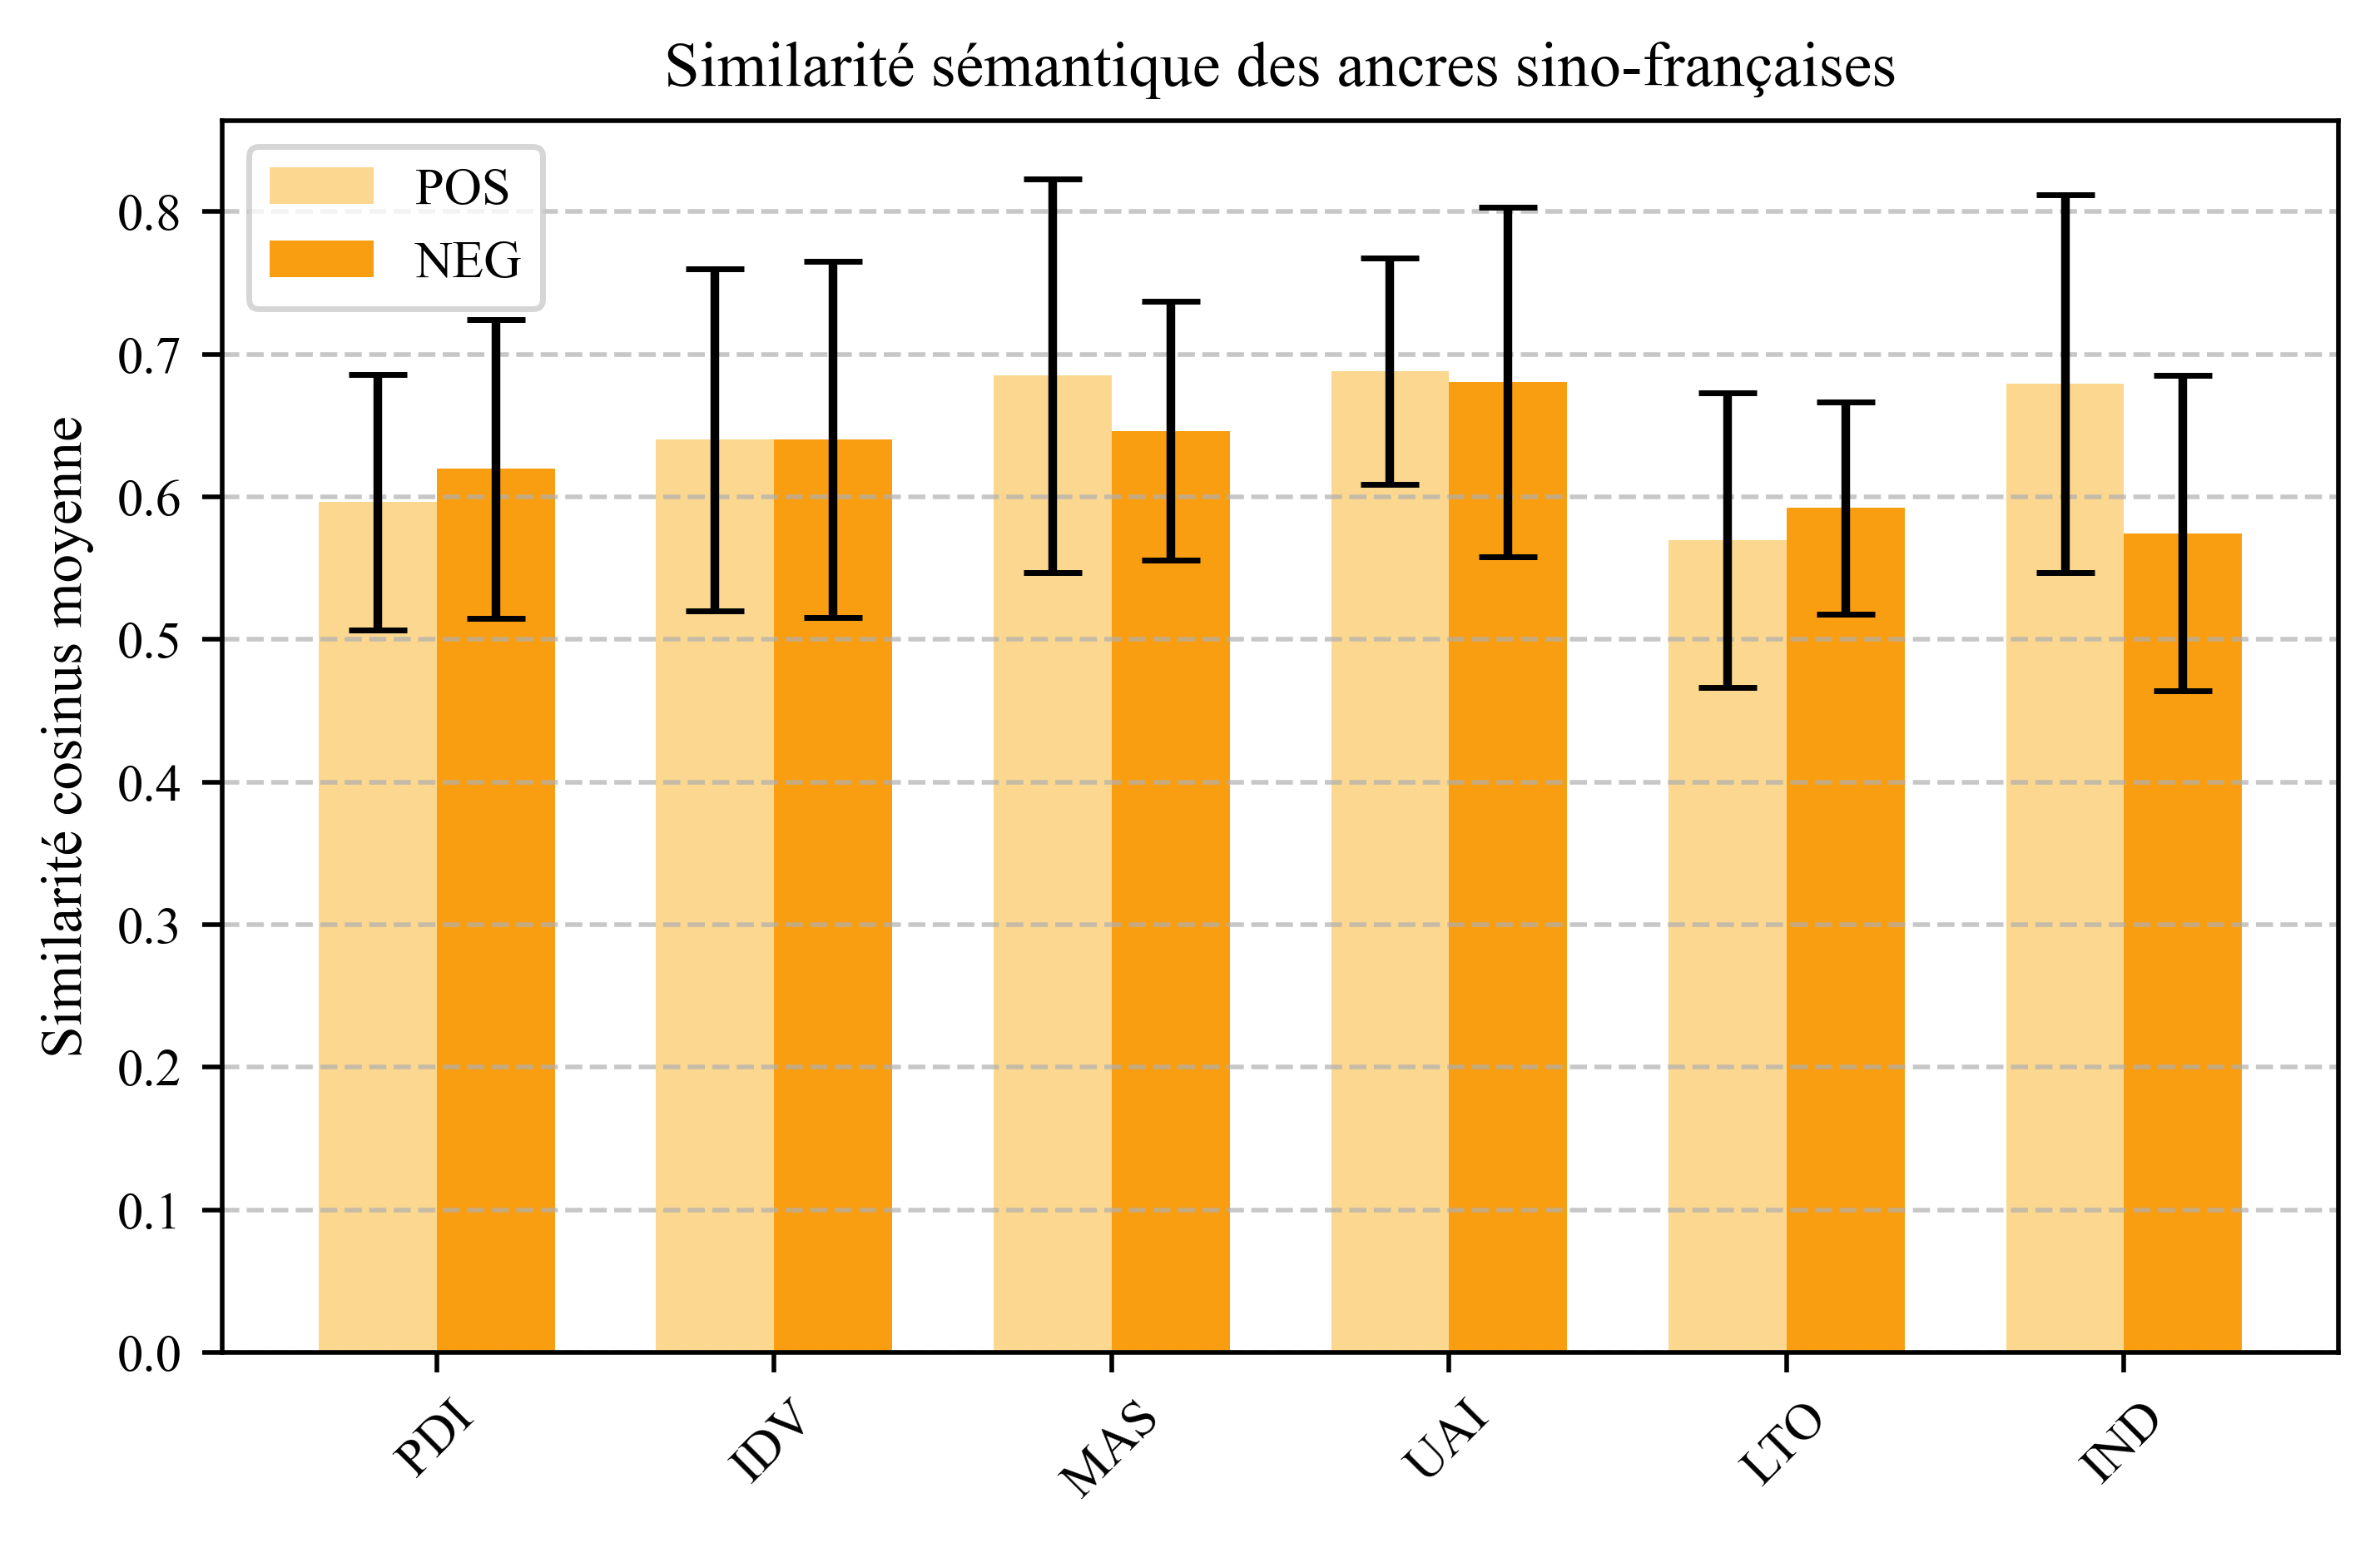

(np.float64(0.6430442031015863),
 np.float64(0.6256239531475046),
 np.float64(0.11035388366878991),
 np.float64(0.10459465030677036))

In [12]:
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix" 
})

# 提取数据
dimensions = list(similarity_stats.keys())
pos_means = [similarity_stats[d]['pos']['mean_cosine'] for d in dimensions]
neg_means = [similarity_stats[d]['neg']['mean_cosine'] for d in dimensions]
pos_stds = [similarity_stats[d]['pos']['std'] for d in dimensions]
neg_stds = [similarity_stats[d]['neg']['std'] for d in dimensions]

x = np.arange(len(dimensions))
width = 0.35

# 绘图
fig, ax = plt.subplots(figsize=(6, 4), dpi=500)
bar1 = ax.bar(x - width/2, pos_means, width, yerr=pos_stds, label='POS', capsize=5, color='#fbd78f')
bar2 = ax.bar(x + width/2, neg_means, width, yerr=neg_stds, label='NEG', capsize=5, color='#f99e11')
ax.set_ylabel("Similarité cosinus moyenne")
ax.set_title("Similarité sémantique des ancres sino-françaises")
ax.set_xticks(x)
ax.set_xticklabels([DIM_ORDER_DICT[d] for d in dimensions], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("similarity_bar_chart.svg", dpi=300, bbox_inches="tight", format="svg")
plt.show()
np.mean(pos_means), np.mean(neg_means), np.mean(pos_stds), np.mean(neg_stds)

### 正负极锚点相似度

In [13]:
# 构造交叉点乘验证函数
async def _cross_validation_one_dim(dim, zh_dict, fr_dict):
    print(f"🔁 Cross-validating: {dim}")
    pos_texts = [e["txt"] for e in zh_dict[dim]["pos"]] + [e["txt"] for e in fr_dict[dim]["pos"]]
    neg_texts = [e["txt"] for e in zh_dict[dim]["neg"]] + [e["txt"] for e in fr_dict[dim]["neg"]]

    pos_embs = await asyncio.gather(*[_get_embedding(txt) for txt in pos_texts])
    neg_embs = await asyncio.gather(*[_get_embedding(txt) for txt in neg_texts])

    pos_arr = np.stack(pos_embs)
    neg_arr = np.stack(neg_embs)

    # 交叉点乘
    scores = pos_arr @ neg_arr.T
    flattened = scores.flatten()

    stats = {
        "cross_mean": float(np.mean(flattened)),
        "std": float(np.std(flattened)),
        "min": float(np.min(flattened)),
        "max": float(np.max(flattened)),
        "count": len(flattened)
    }
    print(f"✅ {dim} → mean: {stats['cross_mean']:.4f}, std: {stats['std']:.4f}")
    return dim, stats

# 主函数
async def run_cross_validation():
    tasks = []
    for i in range(0, len(ALL), 2):
        zh_dict = ALL[i]
        fr_dict = ALL[i + 1]
        for dim in zh_dict:
            tasks.append(_cross_validation_one_dim(dim, zh_dict, fr_dict))
    results = await asyncio.gather(*tasks)
    return {dim: stats for dim, stats in results}

# 执行
cross_validation_results = asyncio.run(run_cross_validation())

🔁 Cross-validating: power_distance
🔁 Cross-validating: individualism
🔁 Cross-validating: motivation_towards_achievement
🔁 Cross-validating: uncertainty_avoidance
🔁 Cross-validating: long_term_orientation
🔁 Cross-validating: indulgence
🔁 Cross-validating: power_distance
🔁 Cross-validating: individualism
🔁 Cross-validating: motivation_towards_achievement
🔁 Cross-validating: uncertainty_avoidance
🔁 Cross-validating: long_term_orientation
🔁 Cross-validating: indulgence
🔁 Cross-validating: power_distance
🔁 Cross-validating: individualism
🔁 Cross-validating: motivation_towards_achievement
🔁 Cross-validating: uncertainty_avoidance
🔁 Cross-validating: long_term_orientation
🔁 Cross-validating: indulgence
🔁 Cross-validating: power_distance
🔁 Cross-validating: individualism
🔁 Cross-validating: motivation_towards_achievement
🔁 Cross-validating: uncertainty_avoidance
🔁 Cross-validating: long_term_orientation
🔁 Cross-validating: indulgence
🔁 Cross-validating: power_distance
🔁 Cross-validating: indiv

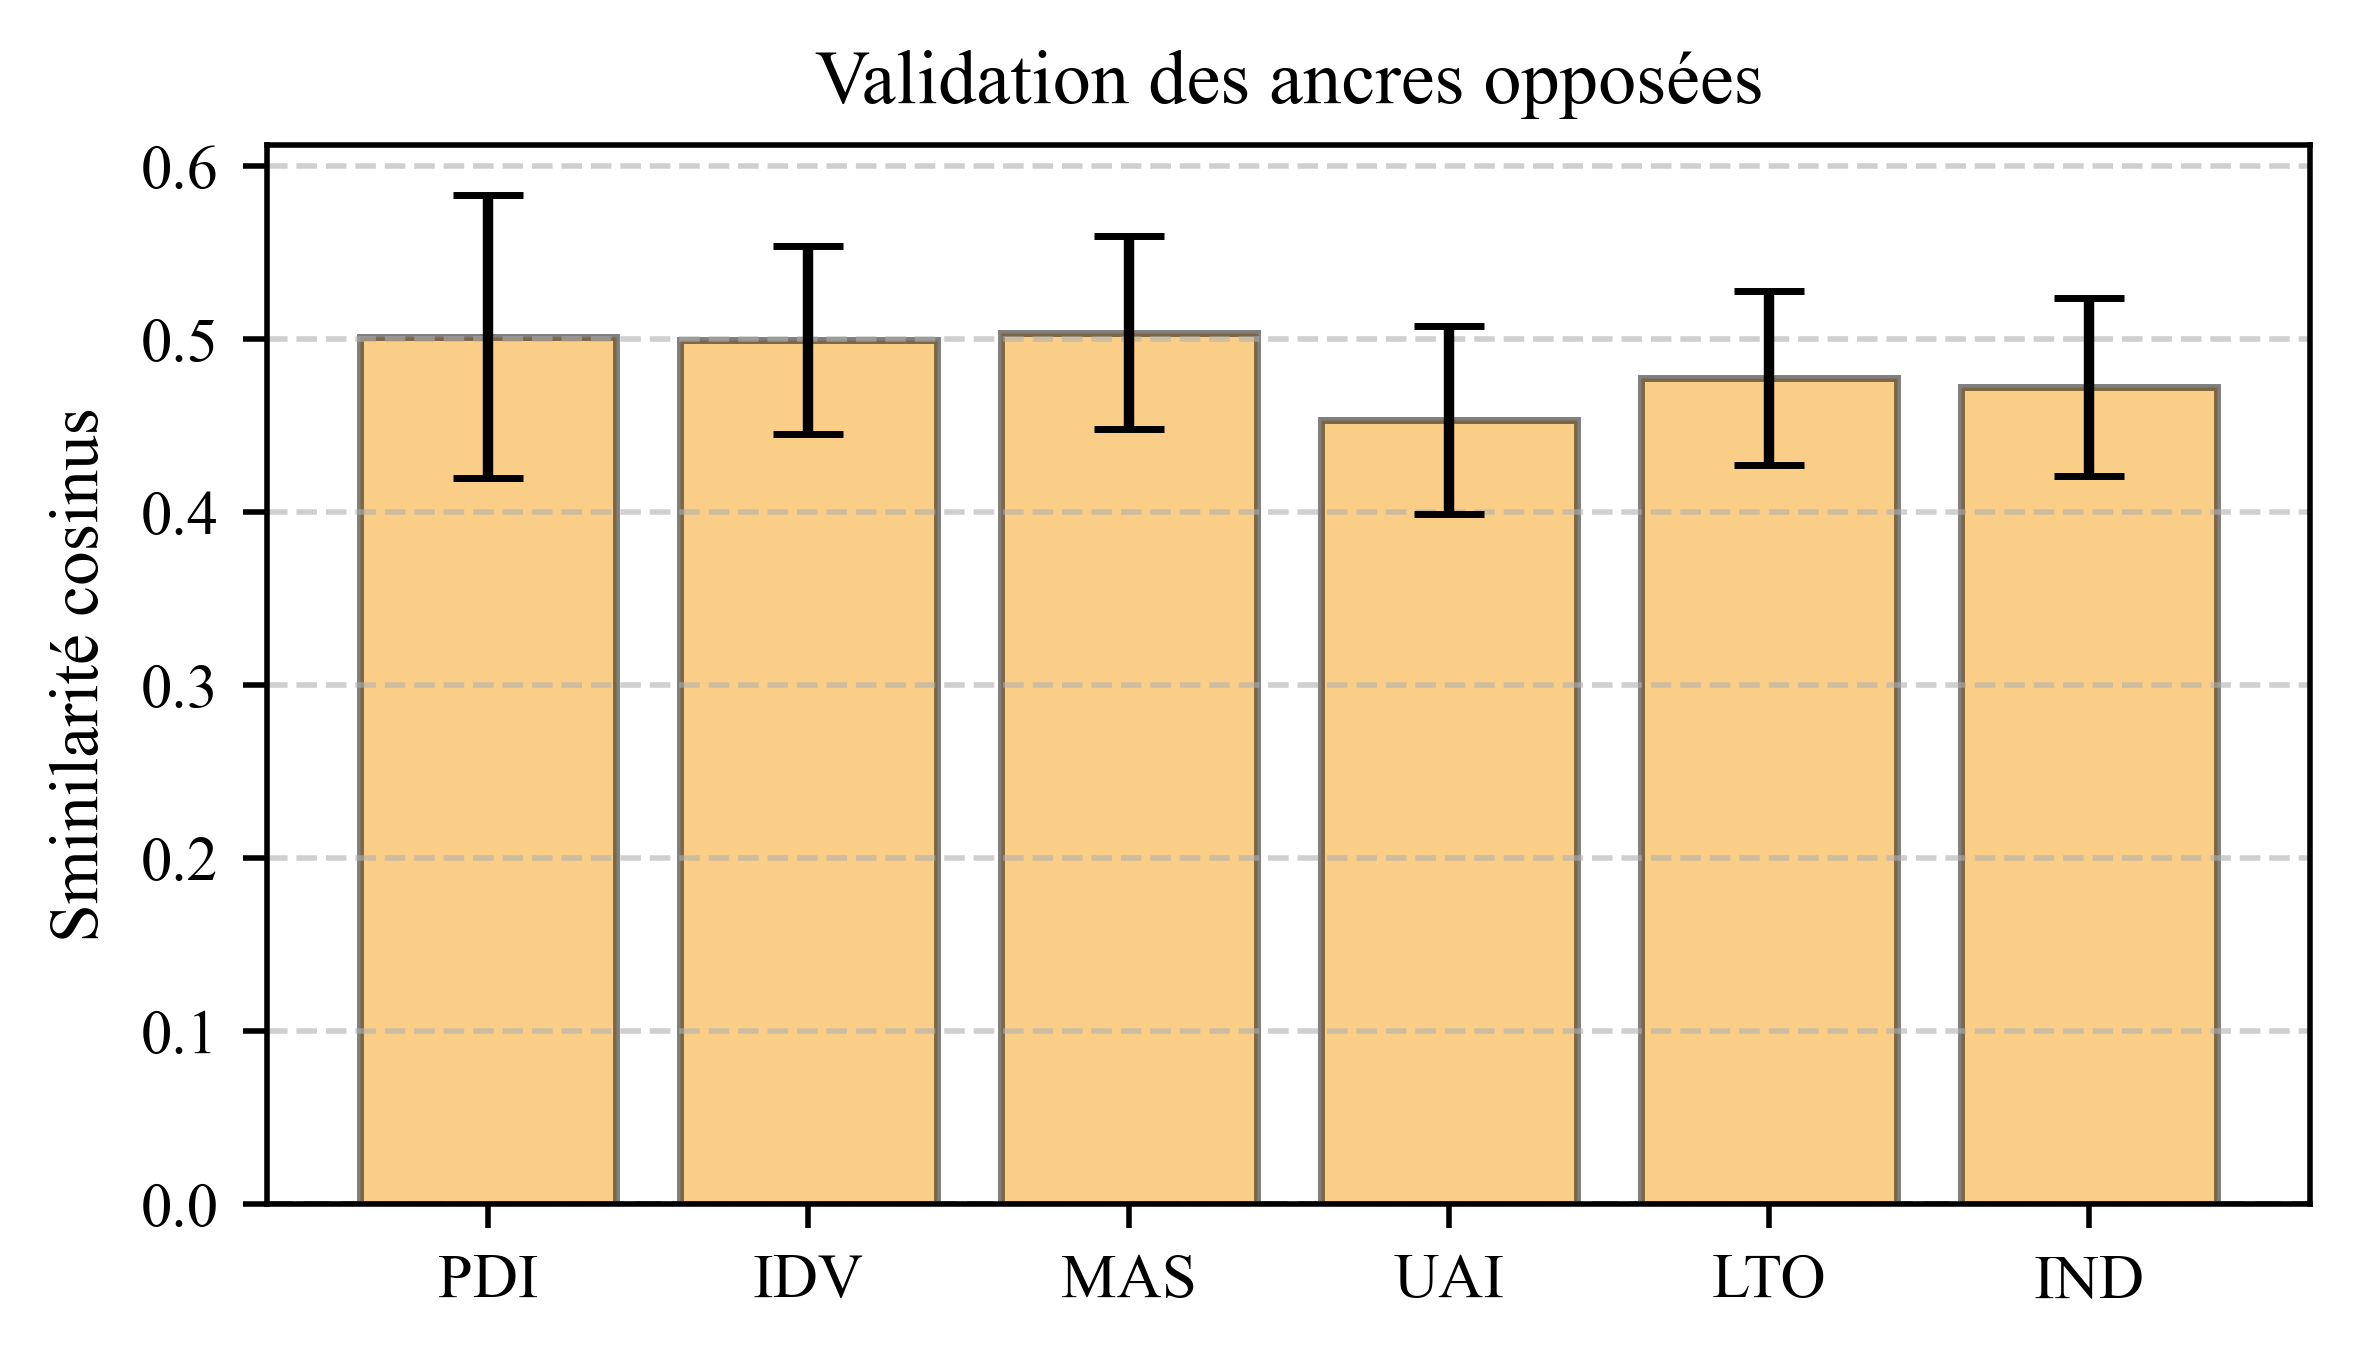

In [14]:
# 准备数据
dims = list(cross_validation_results.keys())
means = [cross_validation_results[d]['cross_mean'] for d in dims]
stds = [cross_validation_results[d]['std'] for d in dims]

# 绘制图表
x = np.arange(len(dims))
fig, ax = plt.subplots(figsize=(5, 3), dpi=500)
bars = ax.bar(x, means, yerr=stds, capsize=5, color='#f99e11', edgecolor='black', alpha=0.5)

# 样式调整
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels([DIM_ORDER_DICT[d] for d in dimensions], rotation=0)
ax.set_ylabel("Sminilarité cosinus")
ax.set_title("Validation des ancres opposées")
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("validation_ancres_opp.svg", dpi=300, bbox_inches="tight", format="svg")
plt.show()

结果表明，尽管正负极锚点是反义词，但他们在语义空间中的夹角都是锐角，说明很多“正负极”词对不是真正的语义反义词，而是表达风格或制度层级不同；例："集中调度" vs "岗位轮换" ≠ "是" vs "不是"，这会导致嵌入距离仍然较小。我们接下来使用极端个例来验证这个现象。

#### 控制组

In [15]:
# 控制组反义锚点示例
control_pairs = [
    ("集中管理", "自主决策"),
    ("规范制度", "流程创新"),
    ("标准流程", "灵活机制")
]

# 定义异步函数计算这些 pairs 的 cosine similarity
async def compute_control_pair_similarities(pairs):
    zh1, zh2 = zip(*pairs)
    emb1 = await asyncio.gather(*[_get_embedding(t) for t in zh1])
    emb2 = await asyncio.gather(*[_get_embedding(t) for t in zh2])
    arr1 = np.stack(emb1)
    arr2 = np.stack(emb2)
    dot = np.sum(arr1 * arr2, axis=1)
    cos_sim = dot / (np.linalg.norm(arr1, axis=1) * np.linalg.norm(arr2, axis=1) + 1e-8)
    return list(zip(pairs, cos_sim))

# 执行
control_similarities = asyncio.run(compute_control_pair_similarities(control_pairs))


In [16]:
control_similarities

[(('集中管理', '自主决策'), np.float64(0.5487046093126648)),
 (('规范制度', '流程创新'), np.float64(0.5438013693969845)),
 (('标准流程', '灵活机制'), np.float64(0.4774881943086562))]

#### 极端控制组

In [17]:
antonym_pairs = [
    ("高", "低"),
    ("多", "少"),
    ("快", "慢"),
    ("真", "假"),
    ("大", "小"),
    ("好", "坏"),
    ("热", "冷"),
    ("强", "弱"),
    ("新", "旧"),
    ("正", "负")
]

control_similarities = asyncio.run(compute_control_pair_similarities(antonym_pairs))
control_similarities

[(('高', '低'), np.float64(0.5157722479743214)),
 (('多', '少'), np.float64(0.6903746612840197)),
 (('快', '慢'), np.float64(0.7196179569056301)),
 (('真', '假'), np.float64(0.6525029918332533)),
 (('大', '小'), np.float64(0.5283640492220063)),
 (('好', '坏'), np.float64(0.5903296738664614)),
 (('热', '冷'), np.float64(0.5964809527871472)),
 (('强', '弱'), np.float64(0.6245562248216849)),
 (('新', '旧'), np.float64(0.6025452650168066)),
 (('正', '负'), np.float64(0.42656054789207937))]

以上结果证明反义词不一定具有负的余弦相似度，猜测相反词汇时常同时出现，导致语义嵌入相似度较高。

进而我们更换思路，采用构造文化方向向量的方式，即$v\_anchor = mean(pos) - mean(neg)$。

### 文化向量有效性检验

同样地，需要证明文化方向向量具有区分度。这里我使用三个方法：

权威基准相关性
- 取 Hofstede 官方国家分数（或其他专家标注数据），将各国文本的平均投影值与基准分数做 Spearman / Pearson 相关。期望：|ρ| ≥ 0.4 且 p < 0.05。
- 已有文章做过类似的验证
  - [The Geometry of Culture: Analyzing Meaning through Word Embeddings](https://arxiv.org/abs/1803.09288)
  - [[PDF] Probing Pre-Trained Language Models for Cross-Cultural ...](https://aclanthology.org/2023.c3nlp-1.12.pdf)

验证1：锚点自检
- 把所有 pos/neg 锚向量分别投影到 v，得到 pos 投影均值 ≫ 0；neg ≪ 0；使用独立样本 t-test / Mann-Whitney U 证明差距显著 
- 注：这不能说明文化向量本身构造合理，因为文化向量自身就是由锚点构造而来的。然而，可以观测文化向量将锚点分开的程度。

验证2：锚点交叉验证
- 把每个领域（finance、public services、industrial、healthcare、education）的 ZH + FR 锚文本合并；
- 预先对所有锚文本做一次嵌入缓存；
- 采用 leave-one-domain-out：4 个领域锚点 → 构造方向 v；用剩下的 1 个领域做检验，记录 pos_mean‒neg_mean 与 t/U 检验 p 值；
- 生成一张交互式结果表 Cross-Domain Anchor Validation（字段：test_domain、dimension、mean_diff、t_p、u_p）。


#### 验证1：锚点自检

In [18]:
from scipy.stats import ttest_ind, mannwhitneyu

# 用已有 anchor_sets 构造 v 向量并自检投影
async def anchor_self_check(anchor_sets):
    # Step 1: 嵌入全部文本
    all_texts = []
    meta = []  # (dim, polarity)
    for dim, groups in anchor_sets.items():
        for polarity in ("pos", "neg"):
            for entry in groups[polarity]:
                all_texts.append(entry["txt"])
                meta.append((dim, polarity, entry["w"]))
    embs = await asyncio.gather(*[_get_embedding(t) for t in all_texts])
    embs = [np.array(e) for e in embs]

    # Step 2: 构造向量字典
    vec_groups = defaultdict(lambda: {"pos": [], "neg": []})
    for (dim, polarity, weight), vec in zip(meta, embs):
        vec_groups[dim][polarity].append((vec, weight))

    # Step 3: 对每个维度执行自检
    results = {}
    for dim, group in vec_groups.items():
        pos_arr = np.stack([v * w for v, w in group["pos"]])
        neg_arr = np.stack([v * w for v, w in group["neg"]])
        pos_mean = pos_arr.sum(0) / (sum(w for _, w in group["pos"]) + 1e-8)
        neg_mean = neg_arr.sum(0) / (sum(w for _, w in group["neg"]) + 1e-8)
        v = pos_mean - neg_mean
        v /= (np.linalg.norm(v) + 1e-8)

        # 投影
        pos_proj = np.array([np.dot(v_, v) for v_, _ in group["pos"]])
        neg_proj = np.array([np.dot(v_, v) for v_, _ in group["neg"]])

        # 统计测试
        t_stat, t_p = ttest_ind(pos_proj, neg_proj, equal_var=False)
        u_stat, u_p = mannwhitneyu(pos_proj, neg_proj, alternative="two-sided")

        results[dim] = {
            "pos_mean": float(pos_proj.mean()),
            "neg_mean": float(neg_proj.mean()),
            "mean_diff": float(pos_proj.mean() - neg_proj.mean()),
            "t_p": float(t_p),
            "u_p": float(u_p)
        }
    return results

# 执行
self_check_results = await anchor_self_check(HOFSTEDE_ANCHOR_SETS)


In [19]:
self_check_results

{'power_distance': {'pos_mean': 0.18194630699587153,
  'neg_mean': -0.1392966817626584,
  'mean_diff': 0.3212429887585299,
  't_p': 1.0552147566806546e-20,
  'u_p': 5.494052450965186e-11},
 'uncertainty_avoidance': {'pos_mean': 0.15276887503906816,
  'neg_mean': -0.14560893424919893,
  'mean_diff': 0.29837780928826707,
  't_p': 1.8383179549070126e-48,
  'u_p': 3.7387215849166554e-21},
 'motivation_towards_achievement': {'pos_mean': 0.22816852229759582,
  'neg_mean': -0.12545641207212277,
  'mean_diff': 0.3536249343697186,
  't_p': 2.5091083629959373e-23,
  'u_p': 3.3383888204288e-11},
 'individualism': {'pos_mean': 0.27655025748015755,
  'neg_mean': -0.18588785642823347,
  'mean_diff': 0.462438113908391,
  't_p': 3.87943873300108e-30,
  'u_p': 3.0179667984904466e-11},
 'long_term_orientation': {'pos_mean': 0.1412699916354381,
  'neg_mean': -0.2308990468745279,
  'mean_diff': 0.37216903850996597,
  't_p': 3.5140097124663507e-23,
  'u_p': 3.019859359162157e-11},
 'indulgence': {'pos_mean

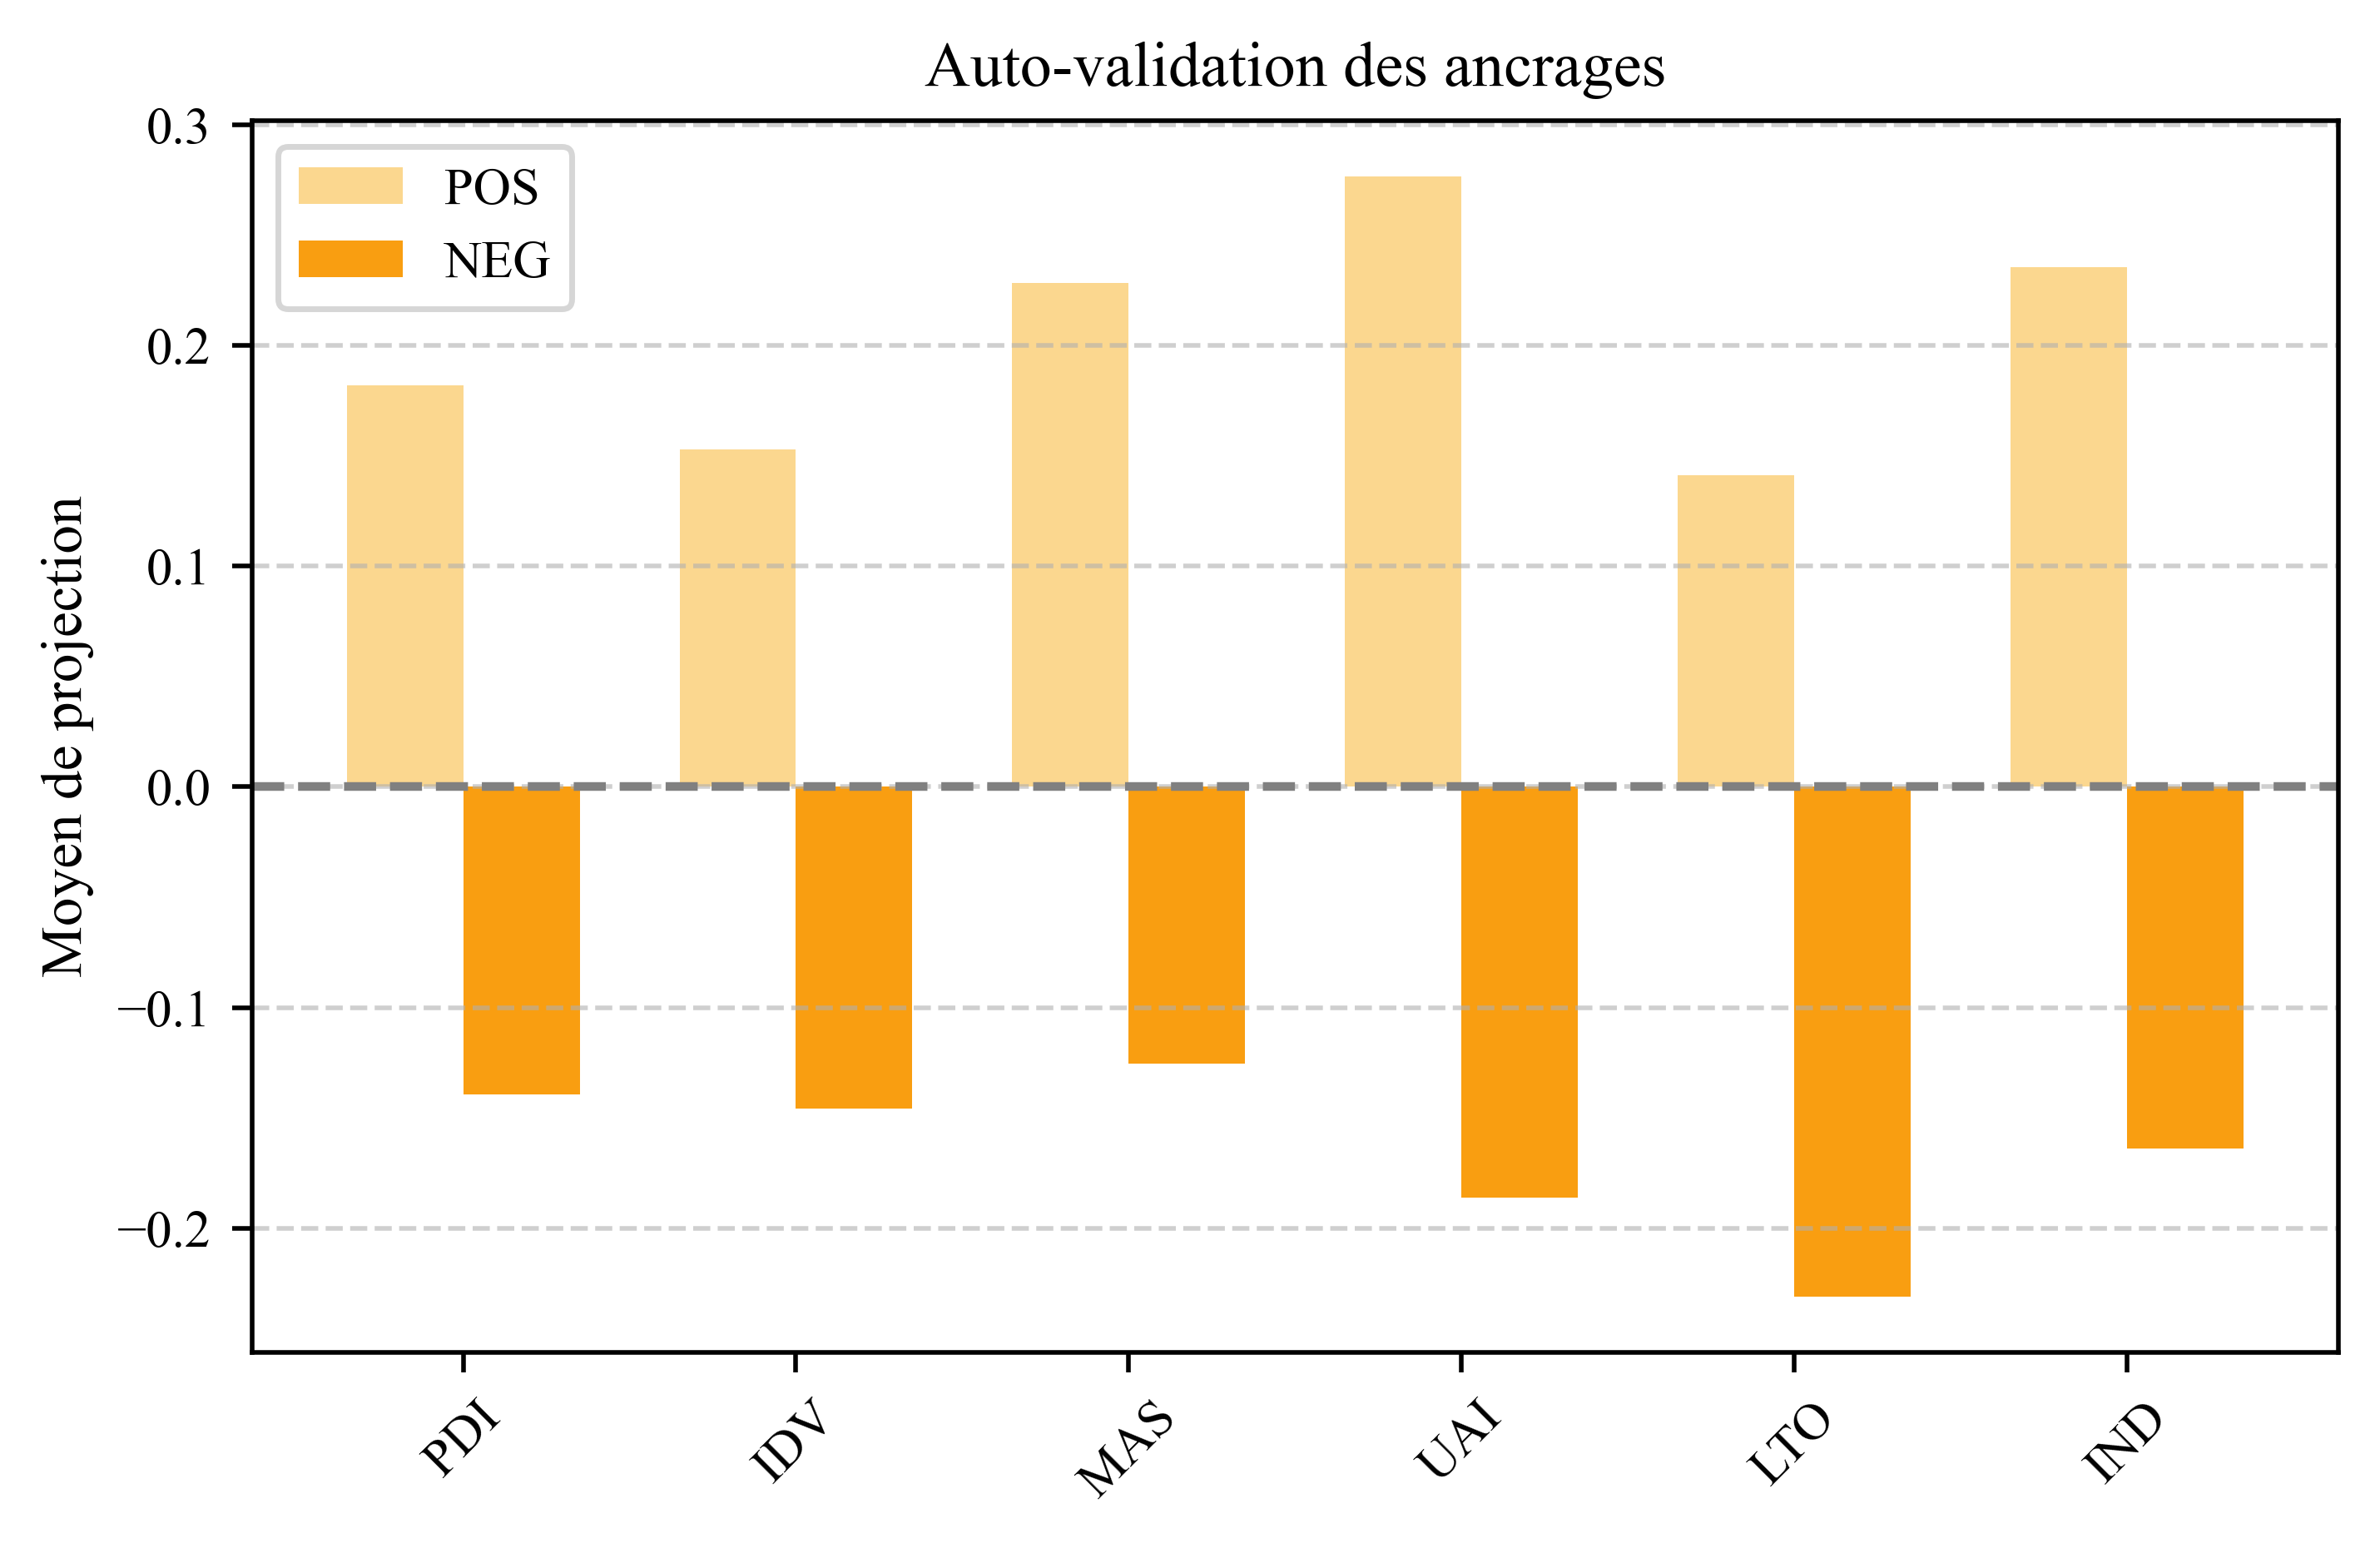

In [20]:
# 准备绘图数据
dims = list(self_check_results.keys())
pos_vals = [self_check_results[d]["pos_mean"] for d in dims]
neg_vals = [self_check_results[d]["neg_mean"] for d in dims]

x = np.arange(len(dims))
width = 0.35

# 绘制柱状图
fig, ax = plt.subplots(figsize=(6, 4), dpi=500)
bar1 = ax.bar(x - width/2, pos_vals, width, label='POS', color='#fbd78f')
bar2 = ax.bar(x + width/2, neg_vals, width, label='NEG', color='#f99e11')

# 添加辅助线与标签
ax.axhline(0, color='gray', linestyle='--')
ax.set_ylabel("Moyen de projection")
ax.set_title("Auto-validation des ancrages")
ax.set_xticks(x)
ax.set_xticklabels([DIM_ORDER_DICT[d] for d in dimensions], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("anchor_self_check.svg", dpi=300, bbox_inches="tight", format="svg")
plt.tight_layout()
plt.show()

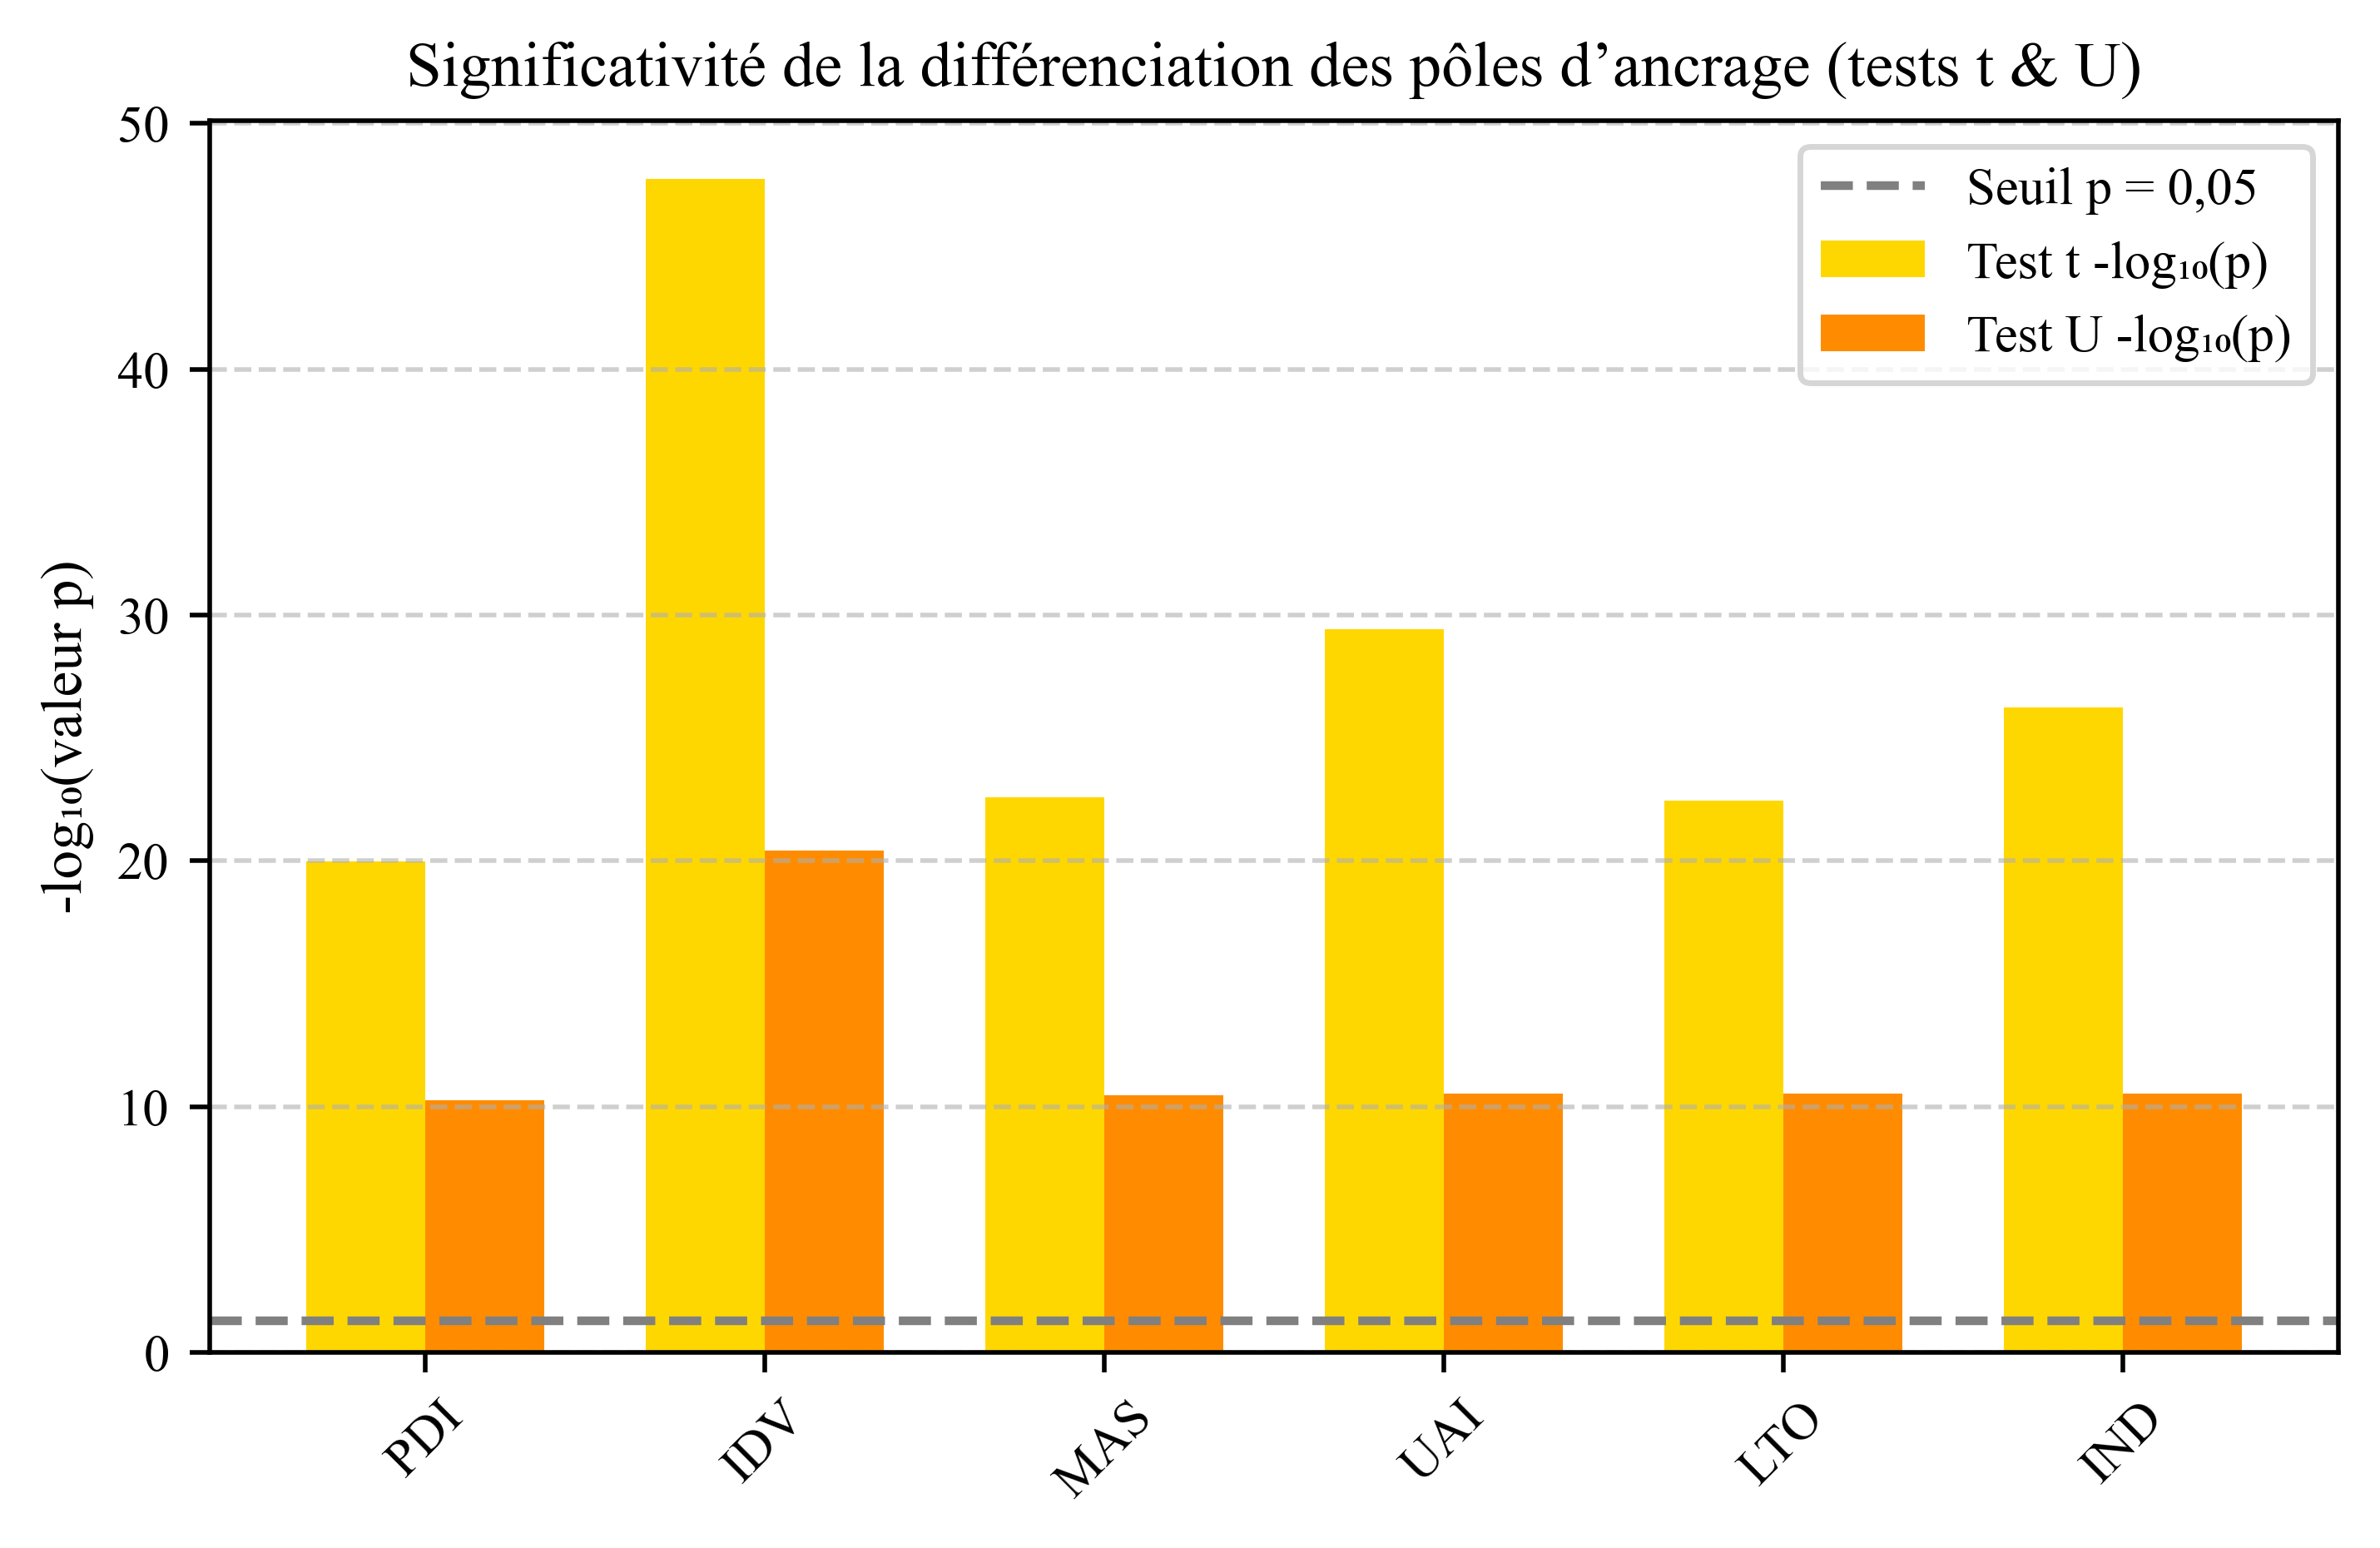

In [21]:
t_pvals = [-np.log10(self_check_results[d]['t_p']) for d in dims]
u_pvals = [-np.log10(self_check_results[d]['u_p']) for d in dims]

x = np.arange(len(dims))
width = 0.35

# Tracé
fig, ax = plt.subplots(figsize=(6, 4), dpi=500)
bar1 = ax.bar(x - width/2, t_pvals, width, label='Test t -log₁₀(p)', color='gold')
bar2 = ax.bar(x + width/2, u_pvals, width, label='Test U -log₁₀(p)', color='darkorange')

ax.axhline(-np.log10(0.05), color='gray', linestyle='--', label='Seuil p = 0,05')
ax.set_ylabel("-log₁₀(valeur p)")
ax.set_title("Significativité de la différenciation des pôles d’ancrage (tests t & U)")
ax.set_xticks(x)
ax.set_xticklabels([DIM_ORDER_DICT[d] for d in dimensions], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("anchor_significance_tests.svg", dpi=300, bbox_inches="tight", format="svg")
plt.show()


#### 验证2：锚点交叉验证

In [22]:
import asyncio, nest_asyncio, numpy as np, pandas as pd
from collections import defaultdict
from scipy.stats import ttest_ind, mannwhitneyu
nest_asyncio.apply()

# ---------- helper: merge zh + fr anchors ----------
def merge_anchor_dict(zh_only, fr_only):
    merged = {}
    for dim in zh_only:
        merged[dim] = {"pos": zh_only[dim]["pos"] + fr_only[dim]["pos"],
                       "neg": zh_only[dim]["neg"] + fr_only[dim]["neg"]}
    return merged

# ---------- domain anchor dicts ----------
domains = {
    "finance": merge_anchor_dict(HOFSTEDE_FINANCE_ZH, HOFSTEDE_FINANCE_FR),
    "public_services": merge_anchor_dict(HOFSTEDE_PUBLIC_SERVICES_ZH, HOFSTEDE_PUBLIC_SERVICES_FR),
    "industrial": merge_anchor_dict(HOFSTEDE_INDUSTRIAL_ZH, HOFSTEDE_INDUSTRIAL_FR),
    "healthcare": merge_anchor_dict(HOFSTEDE_HEALTHCARE_ZH, HOFSTEDE_HEALTHCARE_FR),
    "education": merge_anchor_dict(HOFSTEDE_EDUCATION_ZH, HOFSTEDE_EDUCATION_FR)
}

# ---------- asynchronous embedding ----------
async def embed_texts(texts):
    return await asyncio.gather(*[_get_embedding(t) for t in texts])

# ---------- build v from anchor sets ----------
def build_v(anchor_sets):
    v_dict = {}
    for dim, polar in anchor_sets.items():
        pos_arr = np.stack([np.array(e["emb"]) * e["w"] for e in polar["pos"]])
        neg_arr = np.stack([np.array(e["emb"]) * e["w"] for e in polar["neg"]])
        pos_mean = pos_arr.sum(0) / (pos_arr.shape[0] + 1e-8)
        neg_mean = neg_arr.sum(0) / (neg_arr.shape[0] + 1e-8)
        v = pos_mean - neg_mean
        v_dict[dim] = v / (np.linalg.norm(v) + 1e-8)
    return v_dict

# ---------- cross‑domain validation ----------
async def cross_domain_validation(domains_dict):
    # pre‑embed all anchor texts once
    for dom in domains_dict.values():
        for dim in dom:
            for pol in ("pos", "neg"):
                for item in dom[dim][pol]:
                    if "emb" not in item:
                        item["emb"] = None  # placeholder

    # gather unique texts
    uniq_texts = []
    for dom in domains_dict.values():
        for dim in dom:
            for pol in ("pos", "neg"):
                for item in dom[dim][pol]:
                    uniq_texts.append(item["txt"])
    uniq_texts = list(set(uniq_texts))
    text2emb = dict(zip(uniq_texts, await embed_texts(uniq_texts)))

    # fill embeddings
    for dom in domains_dict.values():
        for dim in dom:
            for pol in ("pos", "neg"):
                for item in dom[dim][pol]:
                    item["emb"] = text2emb[item["txt"]]

    records = []
    all_domain_names = list(domains_dict.keys())
    for test_dom in all_domain_names:
        # build training anchor_sets
        train_sets = defaultdict(lambda: {"pos": [], "neg": []})
        for dom_name, dom_data in domains_dict.items():
            if dom_name == test_dom:
                continue
            for dim in dom_data:
                for pol in ("pos", "neg"):
                    train_sets[dim][pol].extend(dom_data[dim][pol])

        # build anchor sets
        v_dict = build_v(train_sets)

        # evaluate on test domain anchors
        for dim in domains_dict[test_dom]:
            v = v_dict[dim]
            pos_proj = [np.dot(np.array(e["emb"]), v) for e in domains_dict[test_dom][dim]["pos"]]
            neg_proj = [np.dot(np.array(e["emb"]), v) for e in domains_dict[test_dom][dim]["neg"]]
            t_p = ttest_ind(pos_proj, neg_proj, equal_var=False).pvalue
            u_p = mannwhitneyu(pos_proj, neg_proj, alternative="two-sided").pvalue
            records.append({
                "test_domain": test_dom,
                "dimension": dim,
                "pos_mean": np.mean(pos_proj),
                "neg_mean": np.mean(neg_proj),
                "mean_diff": np.mean(pos_proj) - np.mean(neg_proj),
                "t_p": t_p,
                "u_p": u_p
            })
    return pd.DataFrame(records)

# ---------- run validation ----------
df_results = asyncio.run(cross_domain_validation(domains))

# 显示结果表
display(df_results)


2025-05-03 20:40:32,552 - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-05-03 20:40:32,553 - INFO - NumExpr defaulting to 16 threads.


,test_domain,dimension,pos_mean,neg_mean,mean_diff,t_p,u_p
0,finance,power_distance,0.138722,-0.091968,0.230690,2.660924e-04,0.004329
1,finance,individualism,0.297028,-0.173962,0.470990,3.775617e-07,0.002165
2,finance,motivation_towards_achievement,0.201330,-0.018708,0.220039,8.179147e-04,0.002165
3,finance,uncertainty_avoidance,0.087899,-0.116060,0.203959,1.152977e-08,0.000037
4,finance,long_term_orientation,0.095857,-0.195873,0.291730,1.088780e-03,0.002165
5,finance,indulgence,0.207978,-0.107421,0.315399,3.098812e-04,0.002165
6,public_services,power_distance,0.166799,-0.059634,0.226433,2.742288e-03,0.008658
7,public_services,individualism,0.244349,-0.191388,0.435737,1.060988e-04,0.002165
8,public_services,motivation_towards_achievement,0.089910,-0.145018,0.234927,1.882977e-03,0.002165
9,public_services,uncertainty_avoidance,0.117430,-0.066857,0.184287,4.534231e-06,0.000156


In [23]:
print(df_results)

        test_domain                       dimension  pos_mean  neg_mean  \
0           finance                  power_distance  0.138722 -0.091968   
1           finance                   individualism  0.297028 -0.173962   
2           finance  motivation_towards_achievement  0.201330 -0.018708   
3           finance           uncertainty_avoidance  0.087899 -0.116060   
4           finance           long_term_orientation  0.095857 -0.195873   
5           finance                      indulgence  0.207978 -0.107421   
6   public_services                  power_distance  0.166799 -0.059634   
7   public_services                   individualism  0.244349 -0.191388   
8   public_services  motivation_towards_achievement  0.089910 -0.145018   
9   public_services           uncertainty_avoidance  0.117430 -0.066857   
10  public_services           long_term_orientation  0.136238 -0.176024   
11  public_services                      indulgence  0.188429 -0.090661   
12       industrial      

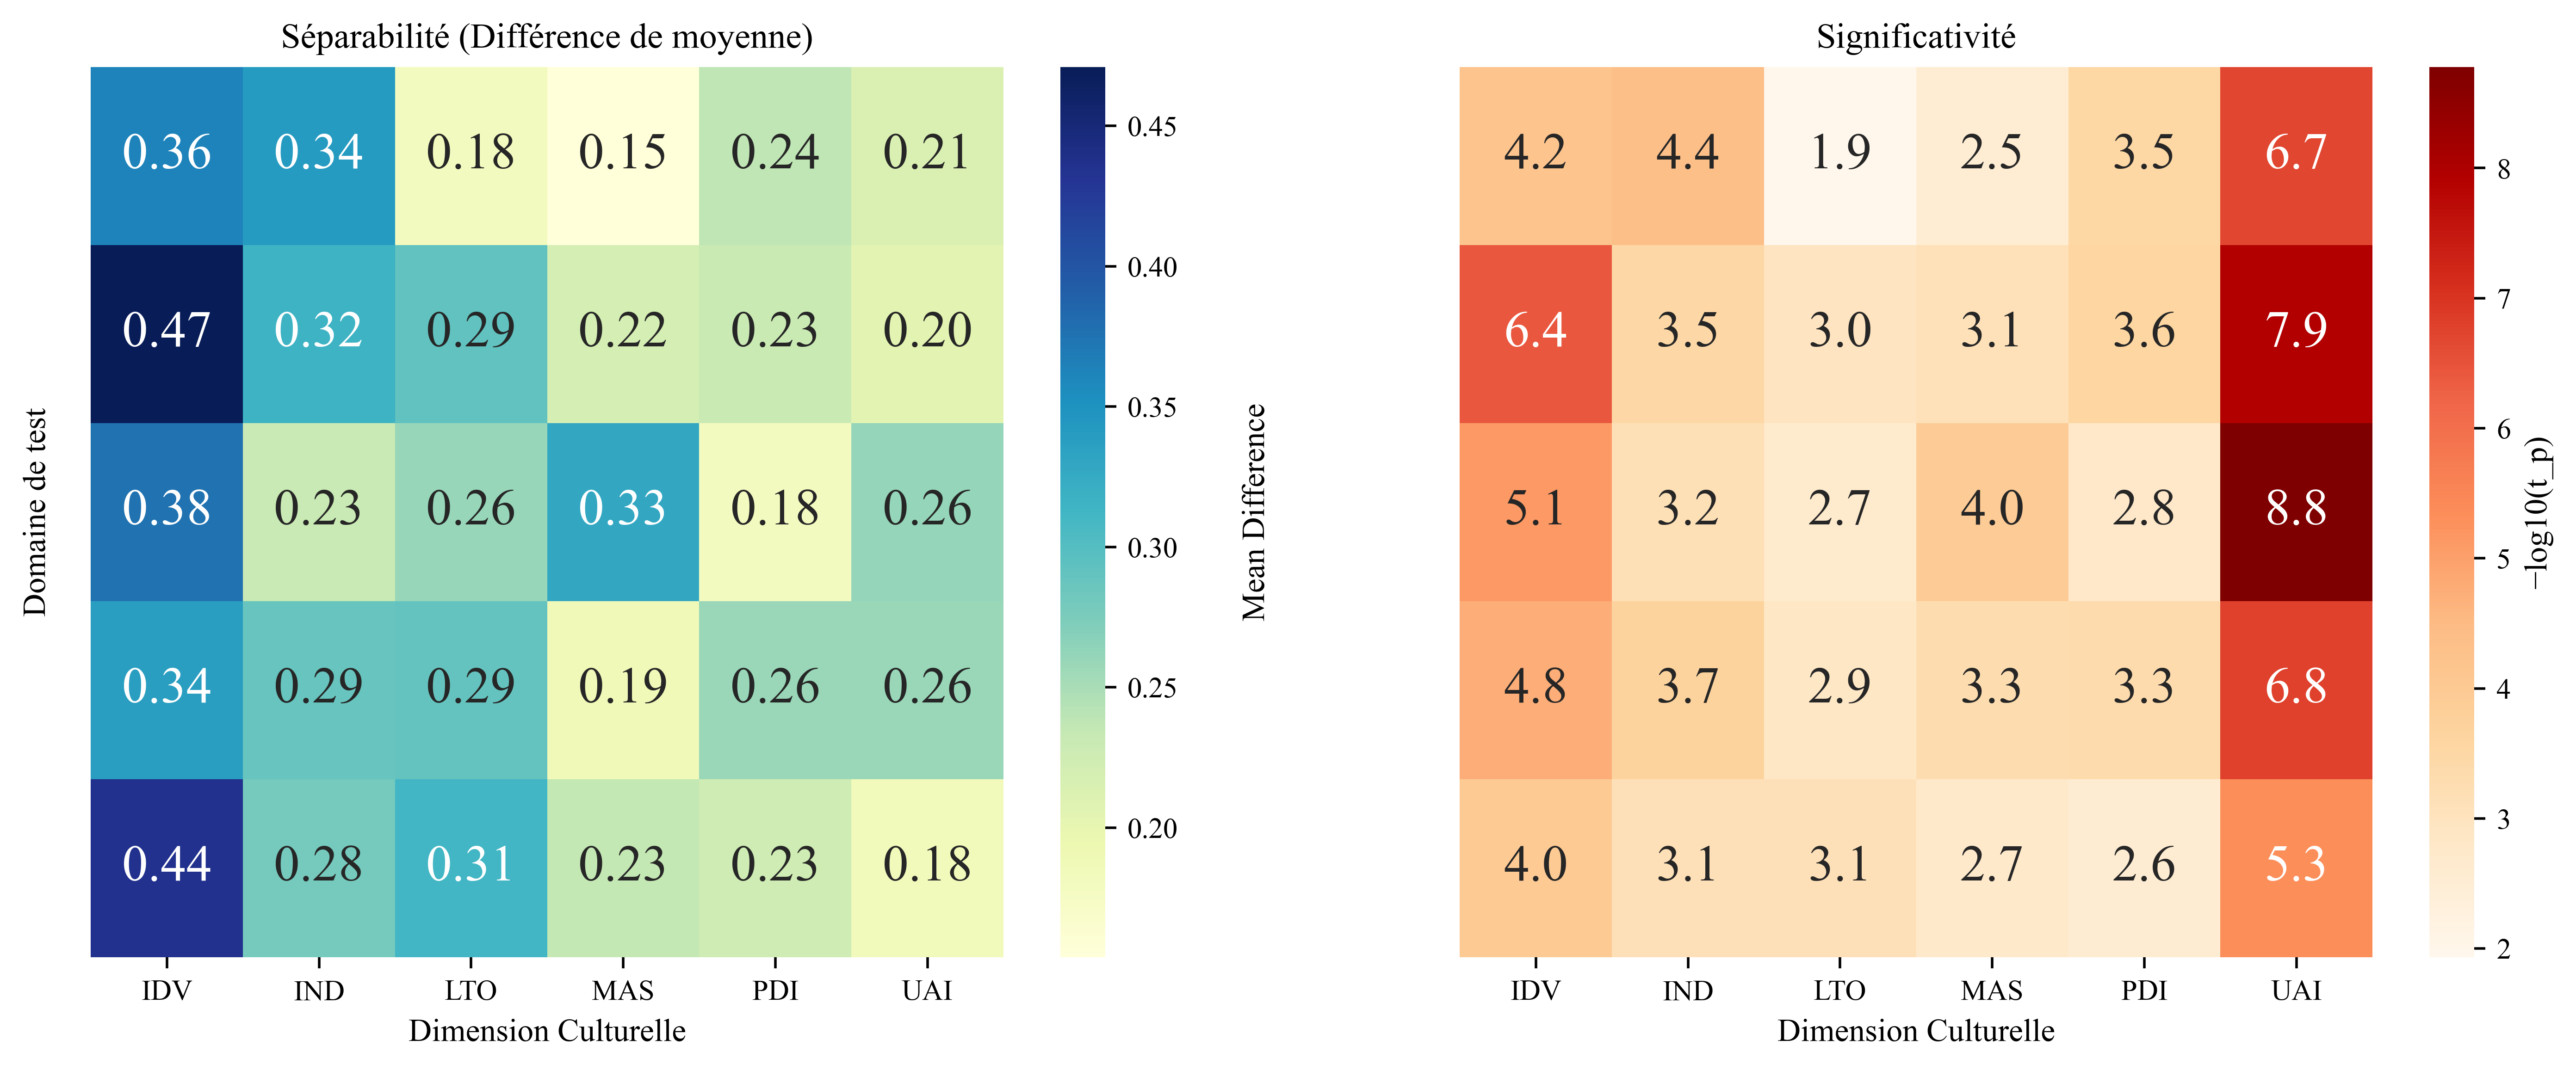

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- pivot ---
pivot_diff = df_results.pivot(index="test_domain", columns="dimension", values="mean_diff")
pivot_logp = (
    df_results
    .assign(t_logp=-np.log10(df_results["t_p"]))
    .pivot(index="test_domain", columns="dimension", values="t_logp")
)

# --- 自定义标签 ---
DIM_MAP = {
    "power_distance": "PDI",
    "individualism": "IDV",
    "motivation_towards_achievement": "MAS",
    "uncertainty_avoidance": "UAI",
    "long_term_orientation": "LTO",
    "indulgence": "IND"
}
DOM_MAP = {"finance": "F", "public_services": "P", "industrial": "I", "healthcare": "H", "education": "E"}

x_labels = [DIM_MAP[d] for d in pivot_diff.columns]
y_labels = [DOM_MAP[d] for d in pivot_diff.index]

# --- 绘图 ---
fig, axes = plt.subplots(
    1, 2,
    figsize=(14, 5),
    sharey=True,
    gridspec_kw={"wspace": 0.2},   # 子图间水平间距
    dpi=500
)

# (a) mean-diff heatmap
h = sns.heatmap(
    pivot_diff.values,
    cmap="YlGnBu",
    annot=True, fmt=".2f",
    xticklabels=x_labels, yticklabels=False,
    cbar_kws={"label": ""},    # 先不让 colorbar 自带标签
    ax=axes[0]
)

axes[0].set_title("Séparabilité (Différence de moyenne)")
axes[0].set_xlabel("Dimension Culturelle")

# 手动放 y-ticks 到单元格中心
axes[0].set_yticks(np.arange(len(y_labels)) + 0.5)
axes[0].set_yticklabels(y_labels, rotation=0)
axes[0].set_ylabel("Domaine de test", labelpad=12)

# 把 colorbar label 移到 heatmap 和 colorbar 之间
cbar = h.collections[0].colorbar
cbar.set_label("Mean Difference", labelpad=20)

# (b) –log10(p) heatmap
h2 = sns.heatmap(
    pivot_logp.values,
    cmap="OrRd",
    annot=True, fmt=".1f",
    xticklabels=x_labels, yticklabels=False,
    cbar_kws={"label": "−log10(t_p)"},
    ax=axes[1]
)

axes[1].set_title("Significativité")
axes[1].set_xlabel("Dimension Culturelle")

# plt.tight_layout()
plt.savefig("cross_domain_validation.svg", dpi=300, bbox_inches="tight", format="svg")
plt.show()


## 基于嵌入的文化投影: 根据描点自检调整

In [25]:
results

{'china': {'power_distance': {'avg_value': 0.013425005683878489,
   'std': 0.08146112470857102,
   'n': 20555},
  'uncertainty_avoidance': {'avg_value': -0.07817533174573288,
   'std': 0.05905912613632271,
   'n': 34405},
  'motivation_towards_achievement': {'avg_value': 0.06292402719691742,
   'std': 0.07881829544299385,
   'n': 30162},
  'individualism': {'avg_value': 0.04717541170467782,
   'std': 0.07500644235116065,
   'n': 22485},
  'long_term_orientation': {'avg_value': 0.0482918904903491,
   'std': 0.08252061175767221,
   'n': 30703},
  'indulgence': {'avg_value': 0.09831786421960778,
   'std': 0.0704183979560216,
   'n': 41214}},
 'france': {'power_distance': {'avg_value': -0.025283583971561243,
   'std': 0.08097814299363246,
   'n': 56283},
  'uncertainty_avoidance': {'avg_value': -0.09414501743271364,
   'std': 0.055020949883330804,
   'n': 100214},
  'motivation_towards_achievement': {'avg_value': -0.030684831415226193,
   'std': 0.08964090751557932,
   'n': 72479},
  'indi

In [26]:
self_check_results

{'power_distance': {'pos_mean': 0.18194630699587153,
  'neg_mean': -0.1392966817626584,
  'mean_diff': 0.3212429887585299,
  't_p': 1.0552147566806546e-20,
  'u_p': 5.494052450965186e-11},
 'uncertainty_avoidance': {'pos_mean': 0.15276887503906816,
  'neg_mean': -0.14560893424919893,
  'mean_diff': 0.29837780928826707,
  't_p': 1.8383179549070126e-48,
  'u_p': 3.7387215849166554e-21},
 'motivation_towards_achievement': {'pos_mean': 0.22816852229759582,
  'neg_mean': -0.12545641207212277,
  'mean_diff': 0.3536249343697186,
  't_p': 2.5091083629959373e-23,
  'u_p': 3.3383888204288e-11},
 'individualism': {'pos_mean': 0.27655025748015755,
  'neg_mean': -0.18588785642823347,
  'mean_diff': 0.462438113908391,
  't_p': 3.87943873300108e-30,
  'u_p': 3.0179667984904466e-11},
 'long_term_orientation': {'pos_mean': 0.1412699916354381,
  'neg_mean': -0.2308990468745279,
  'mean_diff': 0.37216903850996597,
  't_p': 3.5140097124663507e-23,
  'u_p': 3.019859359162157e-11},
 'indulgence': {'pos_mean

In [27]:
# ---------- 计算缩放因子 ----------
scale = {dim: self_check_results[dim]["mean_diff"]
         for dim in self_check_results}

# ---------- 生成 rescaled_results ----------
rescaled_results = {}
for country, dims in results.items():
    rescaled_results[country] = {}
    for dim, stats in dims.items():
        f = scale[dim]                       # mean_diff
        rescaled_results[country][dim] = {
            "avg_value": stats["avg_value"] / f,
            "std":       stats["std"]       / f,
            "n":         stats["n"]
        }

# ---------- 输出检查 ----------
from pprint import pprint
pprint(rescaled_results)

{'china': {'individualism': {'avg_value': 0.10201454051000491,
                             'n': 22485,
                             'std': 0.16219779489460384},
           'indulgence': {'avg_value': 0.246207430296515,
                          'n': 41214,
                          'std': 0.17634163378105377},
           'long_term_orientation': {'avg_value': 0.12975794731257834,
                                     'n': 30703,
                                     'std': 0.22172884689187403},
           'motivation_towards_achievement': {'avg_value': 0.17794001802805479,
                                              'n': 30162,
                                              'std': 0.22288670221593732},
           'power_distance': {'avg_value': 0.04179081304080918,
                              'n': 20555,
                              'std': 0.25358101984850867},
           'uncertainty_avoidance': {'avg_value': -0.26200115863913515,
                                     'n': 34405,
  

In [28]:
generate_cultural_radar_charts(rescaled_results, ylim=(-0.4,0.3), save_path="rescaled_radar.svg")